# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

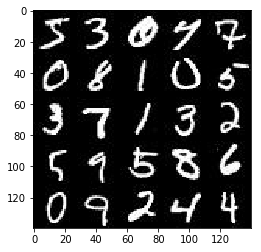

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

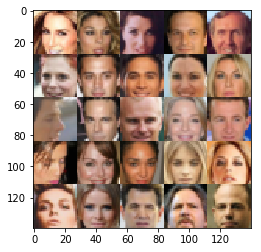

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\ProgramData\\Anaconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\ProgramData\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", li

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Hyperparameters
        alpha = 0.2
        c1_depth = 64
        c2_depth = 128
        c3_depth = 256

        # 28x28 Input        
        c1 = tf.layers.conv2d(images, c1_depth, 5, 2, 'same', activation=None)
        c1 = tf.maximum(c1*alpha, c1) # Leaky ReLu       
        # 14x14        
        c2 = tf.layers.conv2d(c1, c2_depth, 5, 2, 'same', activation=None, use_bias=False)
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = tf.maximum(c2*alpha, c2) # Leaky ReLu 
        # 7x7
        c3 = tf.layers.conv2d(c2, c3_depth, 3, 2, 'same', activation=None, use_bias=False)
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = tf.maximum(c3*alpha, c3) # Leaky ReLu 
        # 4x4 Out
        
        c3_flat_dim = c3_depth*pow(int(c3.get_shape()[1]),2)
        
        flat = tf.reshape(c3, [-1, c3_flat_dim])
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        # Hyperparameters
        alpha = 0.2  
        c1_depth = 1028
        c2_depth = 512
        
        # Flattened input
        f1 = tf.layers.dense(z, 3*3*c1_depth, activation=None, use_bias=False)
        f1 = tf.reshape(f1, [-1, 3, 3, c1_depth])
        f1 = tf.layers.batch_normalization(f1, training=is_train)
        f1 = tf.maximum(alpha*f1, f1) # Leaky ReLu 
        # 3x3
        c1 = tf.layers.conv2d_transpose(f1, c1_depth, 3, 2, 'valid', activation=None, use_bias=False)
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = tf.maximum(alpha*c1, c1) # Leaky ReLu 
        # 7x7
        c2 = tf.layers.conv2d_transpose(c1, c2_depth, 5, 2, 'same', activation=None, use_bias=False)
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = tf.maximum(alpha*c2, c2)
        # 14x14
        logits = tf.layers.conv2d_transpose(c2, out_channel_dim, 5, 2, 'same', activation=None)
        out = tf.tanh(logits)*0.5

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Hyperparameters
    smooth = 0.1
    
    # Model Outputs
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real*(1-smooth))))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables() # Get all trainable variables
    
    # Separate generator and discriminator variables
    g_var = [var for var in t_vars if var.name.startswith('generator')]
    d_var = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Update Batch Norm Population Statistics
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                
                # Show training loss every 10 batches
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch: {}/{}, Discriminator Loss: {:.4f}, Generator Loss: {:.4f}".format(epoch_i, epoch_count, train_loss_d, train_loss_g))
                
                
                # Show generator output every 100 batches
                if step % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                step += 1              
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0/2, Discriminator Loss: 7.9778, Generator Loss: 0.0005


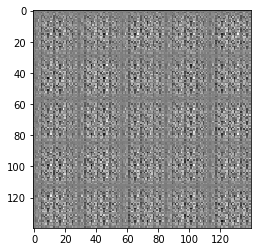

Epoch: 0/2, Discriminator Loss: 1.2382, Generator Loss: 0.4419
Epoch: 0/2, Discriminator Loss: 0.7634, Generator Loss: 0.8170
Epoch: 0/2, Discriminator Loss: 0.3564, Generator Loss: 1.5328
Epoch: 0/2, Discriminator Loss: 0.3336, Generator Loss: 1.6374
Epoch: 0/2, Discriminator Loss: 0.2215, Generator Loss: 2.0963
Epoch: 0/2, Discriminator Loss: 0.2369, Generator Loss: 1.9735
Epoch: 0/2, Discriminator Loss: 0.1490, Generator Loss: 2.4869
Epoch: 0/2, Discriminator Loss: 0.1555, Generator Loss: 2.6360
Epoch: 0/2, Discriminator Loss: 0.1643, Generator Loss: 2.4047
Epoch: 0/2, Discriminator Loss: 0.4951, Generator Loss: 1.2935


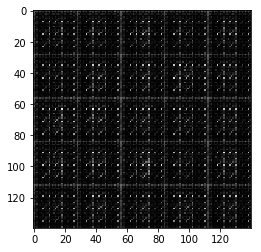

Epoch: 0/2, Discriminator Loss: 0.6206, Generator Loss: 1.5081
Epoch: 0/2, Discriminator Loss: 1.5329, Generator Loss: 0.5047
Epoch: 0/2, Discriminator Loss: 0.9813, Generator Loss: 0.8234
Epoch: 0/2, Discriminator Loss: 1.5531, Generator Loss: 0.6153
Epoch: 0/2, Discriminator Loss: 1.0516, Generator Loss: 0.9664
Epoch: 0/2, Discriminator Loss: 1.1926, Generator Loss: 0.8877
Epoch: 0/2, Discriminator Loss: 0.9456, Generator Loss: 1.1592
Epoch: 0/2, Discriminator Loss: 1.0142, Generator Loss: 1.1157
Epoch: 0/2, Discriminator Loss: 1.2061, Generator Loss: 0.7803
Epoch: 0/2, Discriminator Loss: 1.5400, Generator Loss: 0.5405


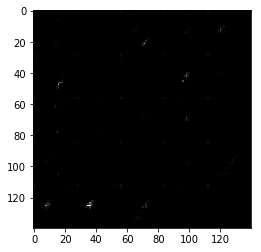

Epoch: 0/2, Discriminator Loss: 1.4679, Generator Loss: 0.6572
Epoch: 0/2, Discriminator Loss: 1.3334, Generator Loss: 0.4914
Epoch: 0/2, Discriminator Loss: 1.4244, Generator Loss: 0.5889
Epoch: 0/2, Discriminator Loss: 1.2472, Generator Loss: 0.6814
Epoch: 0/2, Discriminator Loss: 1.2598, Generator Loss: 0.7849
Epoch: 0/2, Discriminator Loss: 1.4441, Generator Loss: 0.4692
Epoch: 0/2, Discriminator Loss: 1.2239, Generator Loss: 0.5896
Epoch: 0/2, Discriminator Loss: 1.2968, Generator Loss: 0.7627
Epoch: 0/2, Discriminator Loss: 1.3796, Generator Loss: 0.6836
Epoch: 0/2, Discriminator Loss: 1.3242, Generator Loss: 0.7296


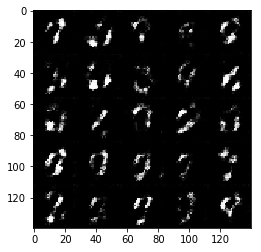

Epoch: 0/2, Discriminator Loss: 1.4430, Generator Loss: 0.6008
Epoch: 0/2, Discriminator Loss: 1.5222, Generator Loss: 0.5073
Epoch: 0/2, Discriminator Loss: 1.4228, Generator Loss: 0.6623
Epoch: 0/2, Discriminator Loss: 1.4946, Generator Loss: 0.7416
Epoch: 0/2, Discriminator Loss: 1.1637, Generator Loss: 0.7398
Epoch: 0/2, Discriminator Loss: 1.3295, Generator Loss: 0.5755
Epoch: 0/2, Discriminator Loss: 1.3099, Generator Loss: 0.5507
Epoch: 0/2, Discriminator Loss: 1.4081, Generator Loss: 0.5944
Epoch: 0/2, Discriminator Loss: 1.4350, Generator Loss: 0.7597
Epoch: 0/2, Discriminator Loss: 1.4005, Generator Loss: 0.8381


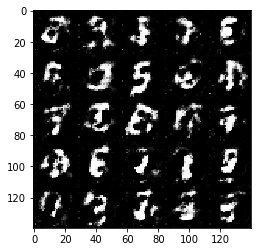

Epoch: 0/2, Discriminator Loss: 1.4582, Generator Loss: 0.9173
Epoch: 0/2, Discriminator Loss: 1.3108, Generator Loss: 0.5791
Epoch: 0/2, Discriminator Loss: 1.3157, Generator Loss: 0.6045
Epoch: 0/2, Discriminator Loss: 1.4902, Generator Loss: 0.4385
Epoch: 0/2, Discriminator Loss: 1.2178, Generator Loss: 0.6698
Epoch: 0/2, Discriminator Loss: 1.2659, Generator Loss: 0.8032
Epoch: 0/2, Discriminator Loss: 1.2101, Generator Loss: 0.7094
Epoch: 0/2, Discriminator Loss: 1.2373, Generator Loss: 0.6250
Epoch: 0/2, Discriminator Loss: 1.3932, Generator Loss: 0.6611
Epoch: 0/2, Discriminator Loss: 1.1985, Generator Loss: 0.7315


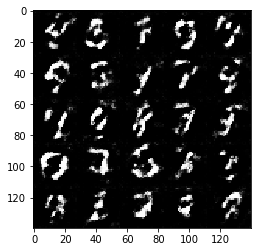

Epoch: 0/2, Discriminator Loss: 1.2196, Generator Loss: 0.7032
Epoch: 0/2, Discriminator Loss: 1.2133, Generator Loss: 0.7014
Epoch: 0/2, Discriminator Loss: 1.5264, Generator Loss: 0.3852
Epoch: 0/2, Discriminator Loss: 1.2068, Generator Loss: 0.6617
Epoch: 0/2, Discriminator Loss: 1.5130, Generator Loss: 0.3150
Epoch: 0/2, Discriminator Loss: 1.2181, Generator Loss: 0.5495
Epoch: 0/2, Discriminator Loss: 1.1057, Generator Loss: 0.7740
Epoch: 0/2, Discriminator Loss: 1.4172, Generator Loss: 0.3941
Epoch: 0/2, Discriminator Loss: 1.1297, Generator Loss: 0.8117
Epoch: 0/2, Discriminator Loss: 1.2270, Generator Loss: 1.0590


Epoch: 0/2, Discriminator Loss: 1.1999, Generator Loss: 0.8749
Epoch: 0/2, Discriminator Loss: 1.2071, Generator Loss: 0.5214
Epoch: 0/2, Discriminator Loss: 1.2801, Generator Loss: 0.8220
Epoch: 0/2, Discriminator Loss: 1.4086, Generator Loss: 0.3937
Epoch: 0/2, Discriminator Loss: 1.1636, Generator Loss: 1.2021
Epoch: 0/2, Discriminator Loss: 1.1930, Generator Loss: 0.5935
Epoch: 0/2, Discriminator Loss: 1.6979, Generator Loss: 0.2735
Epoch: 0/2, Discriminator Loss: 1.2417, Generator Loss: 0.6051
Epoch: 0/2, Discriminator Loss: 1.3659, Generator Loss: 0.4643
Epoch: 0/2, Discriminator Loss: 1.1581, Generator Loss: 0.5922


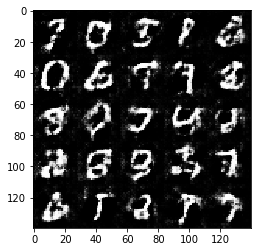

Epoch: 0/2, Discriminator Loss: 1.3317, Generator Loss: 0.6467
Epoch: 0/2, Discriminator Loss: 1.2527, Generator Loss: 0.6678
Epoch: 0/2, Discriminator Loss: 1.4910, Generator Loss: 1.0666
Epoch: 0/2, Discriminator Loss: 1.0788, Generator Loss: 0.9702
Epoch: 0/2, Discriminator Loss: 1.2856, Generator Loss: 0.8594
Epoch: 0/2, Discriminator Loss: 1.0933, Generator Loss: 0.6304
Epoch: 0/2, Discriminator Loss: 1.2203, Generator Loss: 1.0135
Epoch: 0/2, Discriminator Loss: 1.1886, Generator Loss: 0.8797
Epoch: 0/2, Discriminator Loss: 1.2367, Generator Loss: 0.7568
Epoch: 0/2, Discriminator Loss: 1.2366, Generator Loss: 0.8156


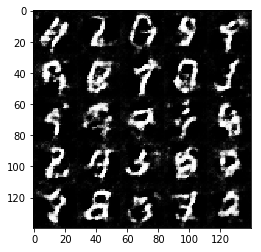

Epoch: 0/2, Discriminator Loss: 1.3118, Generator Loss: 0.8308
Epoch: 0/2, Discriminator Loss: 1.2099, Generator Loss: 0.8094
Epoch: 0/2, Discriminator Loss: 1.4841, Generator Loss: 0.4532
Epoch: 0/2, Discriminator Loss: 1.4302, Generator Loss: 0.4026
Epoch: 0/2, Discriminator Loss: 1.1993, Generator Loss: 0.6306
Epoch: 0/2, Discriminator Loss: 1.3297, Generator Loss: 0.7737
Epoch: 0/2, Discriminator Loss: 1.2798, Generator Loss: 0.5710
Epoch: 0/2, Discriminator Loss: 1.3048, Generator Loss: 0.4714
Epoch: 0/2, Discriminator Loss: 1.1571, Generator Loss: 1.0624
Epoch: 0/2, Discriminator Loss: 1.2938, Generator Loss: 0.5535


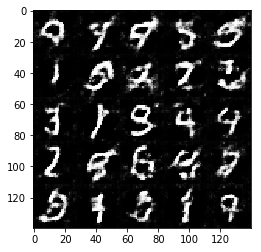

Epoch: 0/2, Discriminator Loss: 1.1663, Generator Loss: 0.9083
Epoch: 0/2, Discriminator Loss: 1.1996, Generator Loss: 0.8319
Epoch: 0/2, Discriminator Loss: 1.2870, Generator Loss: 0.7656
Epoch: 0/2, Discriminator Loss: 1.4441, Generator Loss: 0.6379
Epoch: 0/2, Discriminator Loss: 1.3767, Generator Loss: 0.4570
Epoch: 0/2, Discriminator Loss: 1.1698, Generator Loss: 0.6698
Epoch: 0/2, Discriminator Loss: 1.3398, Generator Loss: 0.9091
Epoch: 0/2, Discriminator Loss: 1.3860, Generator Loss: 0.4329
Epoch: 0/2, Discriminator Loss: 1.1830, Generator Loss: 0.8141
Epoch: 0/2, Discriminator Loss: 1.2659, Generator Loss: 0.9776


Epoch: 0/2, Discriminator Loss: 1.1727, Generator Loss: 0.6996
Epoch: 0/2, Discriminator Loss: 1.1873, Generator Loss: 0.6243
Epoch: 0/2, Discriminator Loss: 1.3877, Generator Loss: 0.9275
Epoch: 0/2, Discriminator Loss: 1.2963, Generator Loss: 0.5965
Epoch: 0/2, Discriminator Loss: 1.1575, Generator Loss: 0.6010
Epoch: 0/2, Discriminator Loss: 1.2553, Generator Loss: 0.5332
Epoch: 0/2, Discriminator Loss: 1.1978, Generator Loss: 0.7394
Epoch: 0/2, Discriminator Loss: 1.4754, Generator Loss: 0.3769
Epoch: 0/2, Discriminator Loss: 1.0991, Generator Loss: 0.7860
Epoch: 0/2, Discriminator Loss: 1.2104, Generator Loss: 0.6867


Epoch: 0/2, Discriminator Loss: 1.1481, Generator Loss: 0.8292
Epoch: 0/2, Discriminator Loss: 1.5723, Generator Loss: 0.3272
Epoch: 0/2, Discriminator Loss: 1.2787, Generator Loss: 0.6332
Epoch: 0/2, Discriminator Loss: 1.2333, Generator Loss: 1.1284
Epoch: 0/2, Discriminator Loss: 1.2244, Generator Loss: 0.5884
Epoch: 0/2, Discriminator Loss: 1.2677, Generator Loss: 0.5036
Epoch: 0/2, Discriminator Loss: 1.3031, Generator Loss: 0.5224
Epoch: 0/2, Discriminator Loss: 1.2901, Generator Loss: 0.6217
Epoch: 0/2, Discriminator Loss: 1.3322, Generator Loss: 0.4688
Epoch: 0/2, Discriminator Loss: 1.1162, Generator Loss: 0.6237


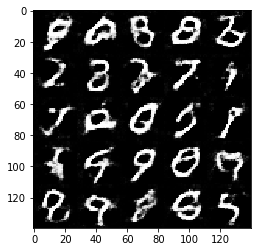

Epoch: 0/2, Discriminator Loss: 1.3054, Generator Loss: 0.4825
Epoch: 0/2, Discriminator Loss: 1.2278, Generator Loss: 0.5298
Epoch: 0/2, Discriminator Loss: 1.3454, Generator Loss: 0.5279
Epoch: 0/2, Discriminator Loss: 1.2172, Generator Loss: 0.9583
Epoch: 0/2, Discriminator Loss: 1.2408, Generator Loss: 0.6174
Epoch: 0/2, Discriminator Loss: 1.1746, Generator Loss: 0.9017
Epoch: 0/2, Discriminator Loss: 1.1843, Generator Loss: 0.9772
Epoch: 0/2, Discriminator Loss: 1.1920, Generator Loss: 0.6537
Epoch: 0/2, Discriminator Loss: 1.2021, Generator Loss: 0.7626
Epoch: 0/2, Discriminator Loss: 1.3112, Generator Loss: 0.7977


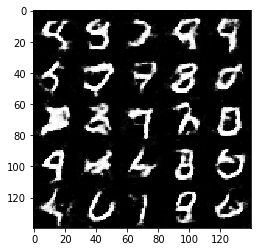

Epoch: 0/2, Discriminator Loss: 1.3458, Generator Loss: 0.4955
Epoch: 0/2, Discriminator Loss: 1.3476, Generator Loss: 0.6172
Epoch: 0/2, Discriminator Loss: 1.2503, Generator Loss: 0.6512
Epoch: 0/2, Discriminator Loss: 1.3815, Generator Loss: 0.4157
Epoch: 0/2, Discriminator Loss: 1.2799, Generator Loss: 0.6173
Epoch: 0/2, Discriminator Loss: 1.1966, Generator Loss: 1.1644
Epoch: 0/2, Discriminator Loss: 1.2157, Generator Loss: 0.5972
Epoch: 0/2, Discriminator Loss: 1.1979, Generator Loss: 0.7717
Epoch: 0/2, Discriminator Loss: 1.1404, Generator Loss: 0.8319
Epoch: 0/2, Discriminator Loss: 1.3324, Generator Loss: 0.8103


Epoch: 0/2, Discriminator Loss: 1.1390, Generator Loss: 0.8625
Epoch: 0/2, Discriminator Loss: 1.3583, Generator Loss: 0.8225
Epoch: 0/2, Discriminator Loss: 1.0840, Generator Loss: 0.7516
Epoch: 0/2, Discriminator Loss: 1.1786, Generator Loss: 0.7676
Epoch: 0/2, Discriminator Loss: 1.1696, Generator Loss: 0.7509
Epoch: 0/2, Discriminator Loss: 1.4126, Generator Loss: 0.4324
Epoch: 0/2, Discriminator Loss: 1.1476, Generator Loss: 0.8514
Epoch: 0/2, Discriminator Loss: 1.0829, Generator Loss: 0.7692
Epoch: 0/2, Discriminator Loss: 1.2739, Generator Loss: 0.5535
Epoch: 0/2, Discriminator Loss: 1.1814, Generator Loss: 0.8896


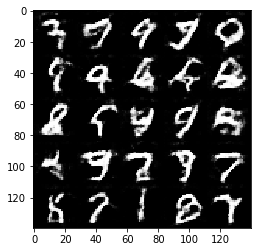

Epoch: 0/2, Discriminator Loss: 1.2446, Generator Loss: 0.8423
Epoch: 0/2, Discriminator Loss: 0.9758, Generator Loss: 0.8288
Epoch: 0/2, Discriminator Loss: 1.2593, Generator Loss: 0.9331
Epoch: 0/2, Discriminator Loss: 1.5119, Generator Loss: 0.4347
Epoch: 0/2, Discriminator Loss: 1.1923, Generator Loss: 0.9251
Epoch: 0/2, Discriminator Loss: 1.1913, Generator Loss: 0.7639
Epoch: 0/2, Discriminator Loss: 1.1547, Generator Loss: 0.7352
Epoch: 0/2, Discriminator Loss: 1.3109, Generator Loss: 0.5604
Epoch: 0/2, Discriminator Loss: 1.2771, Generator Loss: 0.4762
Epoch: 0/2, Discriminator Loss: 1.2819, Generator Loss: 1.0343


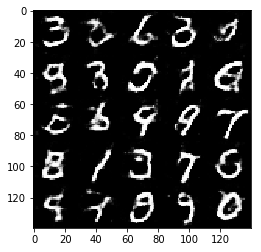

Epoch: 0/2, Discriminator Loss: 1.2393, Generator Loss: 0.9150
Epoch: 0/2, Discriminator Loss: 1.1826, Generator Loss: 0.5961
Epoch: 0/2, Discriminator Loss: 0.9629, Generator Loss: 1.1227
Epoch: 0/2, Discriminator Loss: 1.0241, Generator Loss: 0.9637
Epoch: 0/2, Discriminator Loss: 1.1323, Generator Loss: 0.7010
Epoch: 0/2, Discriminator Loss: 1.3164, Generator Loss: 0.5186
Epoch: 0/2, Discriminator Loss: 1.3591, Generator Loss: 0.4176
Epoch: 0/2, Discriminator Loss: 1.4767, Generator Loss: 0.4090
Epoch: 0/2, Discriminator Loss: 0.9371, Generator Loss: 1.2061
Epoch: 0/2, Discriminator Loss: 1.4955, Generator Loss: 0.3247


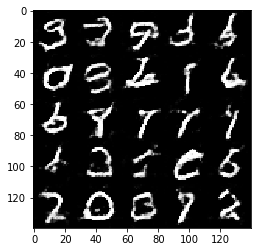

Epoch: 0/2, Discriminator Loss: 1.1534, Generator Loss: 1.0224
Epoch: 0/2, Discriminator Loss: 0.5965, Generator Loss: 1.3037
Epoch: 0/2, Discriminator Loss: 1.1379, Generator Loss: 0.6991
Epoch: 0/2, Discriminator Loss: 1.3361, Generator Loss: 0.4359
Epoch: 0/2, Discriminator Loss: 1.2141, Generator Loss: 0.7779
Epoch: 0/2, Discriminator Loss: 1.0017, Generator Loss: 0.8819
Epoch: 0/2, Discriminator Loss: 1.2368, Generator Loss: 0.5595
Epoch: 0/2, Discriminator Loss: 1.4189, Generator Loss: 0.6423
Epoch: 0/2, Discriminator Loss: 0.9612, Generator Loss: 0.8907
Epoch: 0/2, Discriminator Loss: 1.3565, Generator Loss: 0.5930


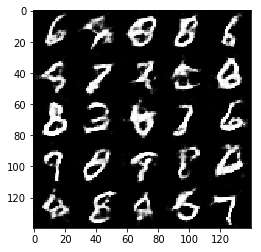

Epoch: 0/2, Discriminator Loss: 1.0335, Generator Loss: 0.7619
Epoch: 0/2, Discriminator Loss: 1.2806, Generator Loss: 0.5502
Epoch: 0/2, Discriminator Loss: 1.0358, Generator Loss: 0.9301
Epoch: 0/2, Discriminator Loss: 0.9600, Generator Loss: 1.1253
Epoch: 0/2, Discriminator Loss: 1.2625, Generator Loss: 0.7393
Epoch: 0/2, Discriminator Loss: 1.0866, Generator Loss: 0.9375
Epoch: 0/2, Discriminator Loss: 1.2081, Generator Loss: 0.6115
Epoch: 1/2, Discriminator Loss: 1.1909, Generator Loss: 0.5616
Epoch: 1/2, Discriminator Loss: 1.1423, Generator Loss: 0.5253
Epoch: 1/2, Discriminator Loss: 1.1586, Generator Loss: 0.6882


Epoch: 1/2, Discriminator Loss: 1.3253, Generator Loss: 0.4334
Epoch: 1/2, Discriminator Loss: 1.0545, Generator Loss: 0.7311
Epoch: 1/2, Discriminator Loss: 1.1333, Generator Loss: 0.6692
Epoch: 1/2, Discriminator Loss: 1.1298, Generator Loss: 0.7170
Epoch: 1/2, Discriminator Loss: 1.2388, Generator Loss: 0.4968
Epoch: 1/2, Discriminator Loss: 1.2871, Generator Loss: 0.5174
Epoch: 1/2, Discriminator Loss: 1.1571, Generator Loss: 0.6071
Epoch: 1/2, Discriminator Loss: 1.1323, Generator Loss: 0.8846
Epoch: 1/2, Discriminator Loss: 1.2598, Generator Loss: 0.5279
Epoch: 1/2, Discriminator Loss: 1.2636, Generator Loss: 0.5448


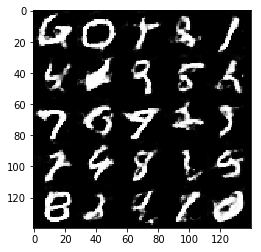

Epoch: 1/2, Discriminator Loss: 1.3426, Generator Loss: 0.4251
Epoch: 1/2, Discriminator Loss: 1.1903, Generator Loss: 0.5869
Epoch: 1/2, Discriminator Loss: 1.1306, Generator Loss: 0.9322
Epoch: 1/2, Discriminator Loss: 0.9998, Generator Loss: 1.0302
Epoch: 1/2, Discriminator Loss: 0.9678, Generator Loss: 0.8047
Epoch: 1/2, Discriminator Loss: 1.0214, Generator Loss: 0.7463
Epoch: 1/2, Discriminator Loss: 1.1763, Generator Loss: 0.5512
Epoch: 1/2, Discriminator Loss: 1.1673, Generator Loss: 0.7122
Epoch: 1/2, Discriminator Loss: 1.1701, Generator Loss: 0.6337
Epoch: 1/2, Discriminator Loss: 1.2888, Generator Loss: 0.4157


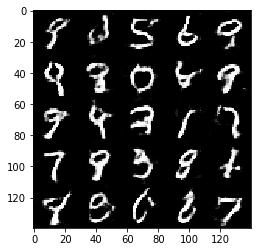

Epoch: 1/2, Discriminator Loss: 1.0542, Generator Loss: 1.0141
Epoch: 1/2, Discriminator Loss: 1.1832, Generator Loss: 0.5299
Epoch: 1/2, Discriminator Loss: 1.1074, Generator Loss: 0.6020
Epoch: 1/2, Discriminator Loss: 1.2771, Generator Loss: 0.4705
Epoch: 1/2, Discriminator Loss: 1.2172, Generator Loss: 1.1434
Epoch: 1/2, Discriminator Loss: 1.0845, Generator Loss: 0.8882
Epoch: 1/2, Discriminator Loss: 1.2098, Generator Loss: 1.1874
Epoch: 1/2, Discriminator Loss: 0.9619, Generator Loss: 0.8766
Epoch: 1/2, Discriminator Loss: 0.9042, Generator Loss: 0.9346
Epoch: 1/2, Discriminator Loss: 0.9893, Generator Loss: 0.9610


Epoch: 1/2, Discriminator Loss: 1.0072, Generator Loss: 0.7759
Epoch: 1/2, Discriminator Loss: 0.9983, Generator Loss: 0.7056
Epoch: 1/2, Discriminator Loss: 1.2374, Generator Loss: 0.4874
Epoch: 1/2, Discriminator Loss: 1.0362, Generator Loss: 0.6062
Epoch: 1/2, Discriminator Loss: 0.9772, Generator Loss: 1.0490
Epoch: 1/2, Discriminator Loss: 1.0669, Generator Loss: 0.6419
Epoch: 1/2, Discriminator Loss: 0.9537, Generator Loss: 1.0915
Epoch: 1/2, Discriminator Loss: 0.9293, Generator Loss: 1.0023
Epoch: 1/2, Discriminator Loss: 0.8205, Generator Loss: 1.2186
Epoch: 1/2, Discriminator Loss: 1.4894, Generator Loss: 0.3260


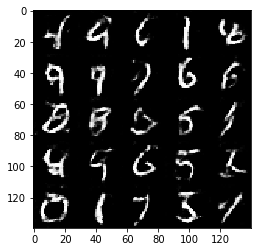

Epoch: 1/2, Discriminator Loss: 1.1430, Generator Loss: 0.6015
Epoch: 1/2, Discriminator Loss: 0.9248, Generator Loss: 0.7916
Epoch: 1/2, Discriminator Loss: 2.1833, Generator Loss: 2.1850
Epoch: 1/2, Discriminator Loss: 0.8109, Generator Loss: 0.9862
Epoch: 1/2, Discriminator Loss: 1.1140, Generator Loss: 0.6018
Epoch: 1/2, Discriminator Loss: 1.2065, Generator Loss: 0.6097
Epoch: 1/2, Discriminator Loss: 0.9108, Generator Loss: 0.9565
Epoch: 1/2, Discriminator Loss: 0.9128, Generator Loss: 0.9847
Epoch: 1/2, Discriminator Loss: 1.0795, Generator Loss: 0.5867
Epoch: 1/2, Discriminator Loss: 0.8745, Generator Loss: 0.9700


Epoch: 1/2, Discriminator Loss: 1.1165, Generator Loss: 0.5702
Epoch: 1/2, Discriminator Loss: 1.2382, Generator Loss: 0.4395
Epoch: 1/2, Discriminator Loss: 1.1168, Generator Loss: 0.9279
Epoch: 1/2, Discriminator Loss: 0.9036, Generator Loss: 0.9687
Epoch: 1/2, Discriminator Loss: 1.1133, Generator Loss: 0.6417
Epoch: 1/2, Discriminator Loss: 1.0916, Generator Loss: 1.2070
Epoch: 1/2, Discriminator Loss: 1.0799, Generator Loss: 1.5334
Epoch: 1/2, Discriminator Loss: 1.0714, Generator Loss: 0.7443
Epoch: 1/2, Discriminator Loss: 0.9524, Generator Loss: 0.7015
Epoch: 1/2, Discriminator Loss: 1.2403, Generator Loss: 0.4395


Epoch: 1/2, Discriminator Loss: 1.4673, Generator Loss: 0.3491
Epoch: 1/2, Discriminator Loss: 1.2949, Generator Loss: 0.4684
Epoch: 1/2, Discriminator Loss: 1.1812, Generator Loss: 0.5451
Epoch: 1/2, Discriminator Loss: 1.0930, Generator Loss: 0.5849
Epoch: 1/2, Discriminator Loss: 1.0317, Generator Loss: 0.6004
Epoch: 1/2, Discriminator Loss: 1.0327, Generator Loss: 0.5989
Epoch: 1/2, Discriminator Loss: 0.8174, Generator Loss: 0.9221
Epoch: 1/2, Discriminator Loss: 1.1879, Generator Loss: 0.5263
Epoch: 1/2, Discriminator Loss: 1.0616, Generator Loss: 0.6184
Epoch: 1/2, Discriminator Loss: 0.9009, Generator Loss: 0.9994


Epoch: 1/2, Discriminator Loss: 0.8172, Generator Loss: 1.0427
Epoch: 1/2, Discriminator Loss: 1.5581, Generator Loss: 0.2856
Epoch: 1/2, Discriminator Loss: 1.2815, Generator Loss: 0.4900
Epoch: 1/2, Discriminator Loss: 1.1271, Generator Loss: 0.6378
Epoch: 1/2, Discriminator Loss: 1.5986, Generator Loss: 0.2893
Epoch: 1/2, Discriminator Loss: 0.8667, Generator Loss: 0.8754
Epoch: 1/2, Discriminator Loss: 0.8985, Generator Loss: 0.8124
Epoch: 1/2, Discriminator Loss: 1.4716, Generator Loss: 0.3252
Epoch: 1/2, Discriminator Loss: 1.2027, Generator Loss: 0.5603
Epoch: 1/2, Discriminator Loss: 1.0929, Generator Loss: 0.6363


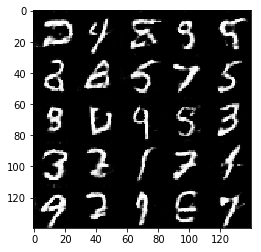

Epoch: 1/2, Discriminator Loss: 1.2968, Generator Loss: 0.4184
Epoch: 1/2, Discriminator Loss: 0.8641, Generator Loss: 1.2421
Epoch: 1/2, Discriminator Loss: 0.9955, Generator Loss: 0.7206
Epoch: 1/2, Discriminator Loss: 0.8091, Generator Loss: 1.0825
Epoch: 1/2, Discriminator Loss: 0.8448, Generator Loss: 1.3447
Epoch: 1/2, Discriminator Loss: 0.9173, Generator Loss: 1.2128
Epoch: 1/2, Discriminator Loss: 1.0724, Generator Loss: 0.6735
Epoch: 1/2, Discriminator Loss: 1.0466, Generator Loss: 0.5931
Epoch: 1/2, Discriminator Loss: 1.5234, Generator Loss: 1.1545
Epoch: 1/2, Discriminator Loss: 0.9987, Generator Loss: 1.1455


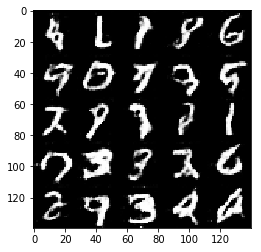

Epoch: 1/2, Discriminator Loss: 0.9837, Generator Loss: 0.6668
Epoch: 1/2, Discriminator Loss: 0.8363, Generator Loss: 0.8746
Epoch: 1/2, Discriminator Loss: 0.6335, Generator Loss: 1.1225
Epoch: 1/2, Discriminator Loss: 1.2127, Generator Loss: 0.5095
Epoch: 1/2, Discriminator Loss: 0.8038, Generator Loss: 0.9431
Epoch: 1/2, Discriminator Loss: 1.1130, Generator Loss: 0.5641
Epoch: 1/2, Discriminator Loss: 0.9300, Generator Loss: 0.7456
Epoch: 1/2, Discriminator Loss: 0.9202, Generator Loss: 0.7346
Epoch: 1/2, Discriminator Loss: 1.6594, Generator Loss: 0.2548
Epoch: 1/2, Discriminator Loss: 0.9135, Generator Loss: 0.8421


Epoch: 1/2, Discriminator Loss: 1.4495, Generator Loss: 0.3207
Epoch: 1/2, Discriminator Loss: 1.0276, Generator Loss: 0.6851
Epoch: 1/2, Discriminator Loss: 0.8719, Generator Loss: 0.7954
Epoch: 1/2, Discriminator Loss: 1.7367, Generator Loss: 0.2431
Epoch: 1/2, Discriminator Loss: 0.9742, Generator Loss: 0.6778
Epoch: 1/2, Discriminator Loss: 0.8895, Generator Loss: 0.7072
Epoch: 1/2, Discriminator Loss: 1.1931, Generator Loss: 0.4924
Epoch: 1/2, Discriminator Loss: 1.0151, Generator Loss: 0.6443
Epoch: 1/2, Discriminator Loss: 0.8814, Generator Loss: 0.9106
Epoch: 1/2, Discriminator Loss: 1.0274, Generator Loss: 0.6776


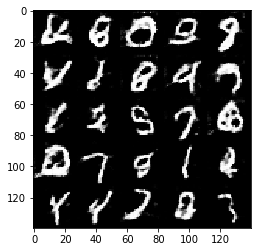

Epoch: 1/2, Discriminator Loss: 1.2987, Generator Loss: 0.4397
Epoch: 1/2, Discriminator Loss: 1.1607, Generator Loss: 0.4638
Epoch: 1/2, Discriminator Loss: 0.7535, Generator Loss: 1.0248
Epoch: 1/2, Discriminator Loss: 0.6214, Generator Loss: 1.0755
Epoch: 1/2, Discriminator Loss: 0.8777, Generator Loss: 0.8998
Epoch: 1/2, Discriminator Loss: 0.6279, Generator Loss: 1.0386
Epoch: 1/2, Discriminator Loss: 0.8159, Generator Loss: 0.8519
Epoch: 1/2, Discriminator Loss: 0.8955, Generator Loss: 0.7223
Epoch: 1/2, Discriminator Loss: 1.9565, Generator Loss: 1.7868
Epoch: 1/2, Discriminator Loss: 0.9898, Generator Loss: 0.7526


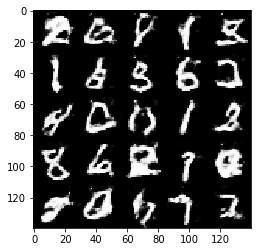

Epoch: 1/2, Discriminator Loss: 0.9345, Generator Loss: 0.6809
Epoch: 1/2, Discriminator Loss: 0.9554, Generator Loss: 0.8001
Epoch: 1/2, Discriminator Loss: 0.5377, Generator Loss: 1.3823
Epoch: 1/2, Discriminator Loss: 1.0123, Generator Loss: 0.8151
Epoch: 1/2, Discriminator Loss: 0.7993, Generator Loss: 0.9463
Epoch: 1/2, Discriminator Loss: 1.1449, Generator Loss: 0.5618
Epoch: 1/2, Discriminator Loss: 1.0070, Generator Loss: 0.6460
Epoch: 1/2, Discriminator Loss: 0.9224, Generator Loss: 0.6851
Epoch: 1/2, Discriminator Loss: 1.1201, Generator Loss: 0.5608
Epoch: 1/2, Discriminator Loss: 1.0159, Generator Loss: 0.6556


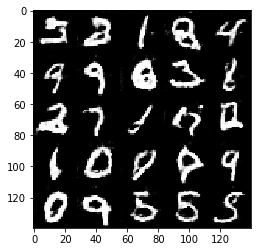

Epoch: 1/2, Discriminator Loss: 1.0190, Generator Loss: 0.9682
Epoch: 1/2, Discriminator Loss: 0.9127, Generator Loss: 0.9469
Epoch: 1/2, Discriminator Loss: 0.7842, Generator Loss: 0.9496
Epoch: 1/2, Discriminator Loss: 1.1502, Generator Loss: 0.5958
Epoch: 1/2, Discriminator Loss: 1.0393, Generator Loss: 0.5502
Epoch: 1/2, Discriminator Loss: 1.0921, Generator Loss: 0.6418
Epoch: 1/2, Discriminator Loss: 0.9569, Generator Loss: 0.6423
Epoch: 1/2, Discriminator Loss: 0.9157, Generator Loss: 0.8075
Epoch: 1/2, Discriminator Loss: 0.8555, Generator Loss: 1.1491
Epoch: 1/2, Discriminator Loss: 1.2350, Generator Loss: 0.4250


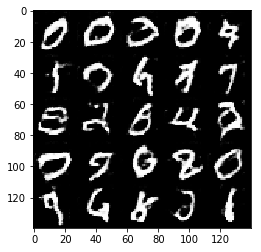

Epoch: 1/2, Discriminator Loss: 1.9957, Generator Loss: 0.2324
Epoch: 1/2, Discriminator Loss: 1.0587, Generator Loss: 0.6889
Epoch: 1/2, Discriminator Loss: 1.2114, Generator Loss: 0.4760
Epoch: 1/2, Discriminator Loss: 0.8086, Generator Loss: 0.9103
Epoch: 1/2, Discriminator Loss: 0.9167, Generator Loss: 0.7840
Epoch: 1/2, Discriminator Loss: 0.9476, Generator Loss: 0.6107
Epoch: 1/2, Discriminator Loss: 0.8635, Generator Loss: 1.1447
Epoch: 1/2, Discriminator Loss: 0.6414, Generator Loss: 1.2098
Epoch: 1/2, Discriminator Loss: 1.2757, Generator Loss: 0.4766
Epoch: 1/2, Discriminator Loss: 0.6735, Generator Loss: 1.2385


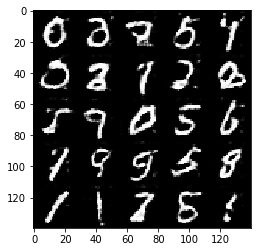

Epoch: 1/2, Discriminator Loss: 0.7524, Generator Loss: 0.9348
Epoch: 1/2, Discriminator Loss: 0.8910, Generator Loss: 0.8202
Epoch: 1/2, Discriminator Loss: 0.7151, Generator Loss: 1.1888
Epoch: 1/2, Discriminator Loss: 1.0212, Generator Loss: 0.5991
Epoch: 1/2, Discriminator Loss: 0.9289, Generator Loss: 1.0536
Epoch: 1/2, Discriminator Loss: 0.9058, Generator Loss: 0.9323
Epoch: 1/2, Discriminator Loss: 0.7595, Generator Loss: 0.8418
Epoch: 1/2, Discriminator Loss: 1.8026, Generator Loss: 0.2405
Epoch: 1/2, Discriminator Loss: 0.8234, Generator Loss: 0.8191
Epoch: 1/2, Discriminator Loss: 0.7880, Generator Loss: 0.8754


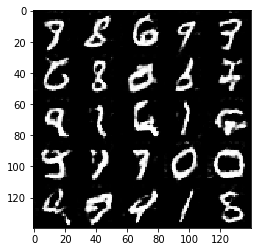

Epoch: 1/2, Discriminator Loss: 0.5493, Generator Loss: 1.7758
Epoch: 1/2, Discriminator Loss: 0.7224, Generator Loss: 0.9627
Epoch: 1/2, Discriminator Loss: 1.2047, Generator Loss: 0.5290
Epoch: 1/2, Discriminator Loss: 1.3171, Generator Loss: 0.4757
Epoch: 1/2, Discriminator Loss: 0.7168, Generator Loss: 0.9290
Epoch: 1/2, Discriminator Loss: 1.3197, Generator Loss: 0.4167
Epoch: 1/2, Discriminator Loss: 1.8333, Generator Loss: 0.2191
Epoch: 1/2, Discriminator Loss: 0.5662, Generator Loss: 1.1281
Epoch: 1/2, Discriminator Loss: 1.0555, Generator Loss: 2.1047
Epoch: 1/2, Discriminator Loss: 0.7497, Generator Loss: 0.9017


Epoch: 1/2, Discriminator Loss: 0.5318, Generator Loss: 1.3691
Epoch: 1/2, Discriminator Loss: 0.9091, Generator Loss: 0.7278
Epoch: 1/2, Discriminator Loss: 0.5022, Generator Loss: 1.3835
Epoch: 1/2, Discriminator Loss: 0.7770, Generator Loss: 0.9485
Epoch: 1/2, Discriminator Loss: 0.8327, Generator Loss: 0.6707
Epoch: 1/2, Discriminator Loss: 1.4458, Generator Loss: 0.3594
Epoch: 1/2, Discriminator Loss: 0.7295, Generator Loss: 0.9485
Epoch: 1/2, Discriminator Loss: 0.8467, Generator Loss: 0.8799
Epoch: 1/2, Discriminator Loss: 0.7750, Generator Loss: 1.1965
Epoch: 1/2, Discriminator Loss: 1.0089, Generator Loss: 0.8527


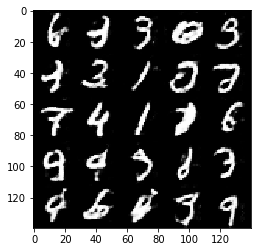

Epoch: 1/2, Discriminator Loss: 0.8119, Generator Loss: 0.9250
Epoch: 1/2, Discriminator Loss: 0.7920, Generator Loss: 1.0195
Epoch: 1/2, Discriminator Loss: 1.2620, Generator Loss: 0.4085
Epoch: 1/2, Discriminator Loss: 0.8279, Generator Loss: 0.8672


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0/1, Discriminator Loss: 8.9258, Generator Loss: 0.0003


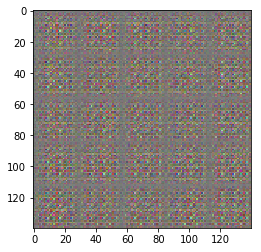

Epoch: 0/1, Discriminator Loss: 6.0948, Generator Loss: 0.0053
Epoch: 0/1, Discriminator Loss: 3.1376, Generator Loss: 0.0942
Epoch: 0/1, Discriminator Loss: 1.9418, Generator Loss: 0.3302
Epoch: 0/1, Discriminator Loss: 1.4435, Generator Loss: 0.5037
Epoch: 0/1, Discriminator Loss: 0.7690, Generator Loss: 1.2580
Epoch: 0/1, Discriminator Loss: 0.9984, Generator Loss: 1.0436
Epoch: 0/1, Discriminator Loss: 1.0549, Generator Loss: 1.2714
Epoch: 0/1, Discriminator Loss: 0.6165, Generator Loss: 1.2229
Epoch: 0/1, Discriminator Loss: 0.5199, Generator Loss: 1.4763
Epoch: 0/1, Discriminator Loss: 0.6101, Generator Loss: 1.2797


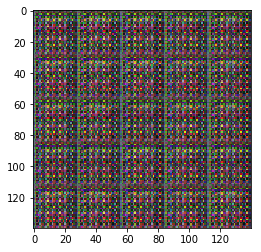

Epoch: 0/1, Discriminator Loss: 0.3827, Generator Loss: 1.6236
Epoch: 0/1, Discriminator Loss: 0.7338, Generator Loss: 1.1120
Epoch: 0/1, Discriminator Loss: 0.6483, Generator Loss: 1.2796
Epoch: 0/1, Discriminator Loss: 0.5580, Generator Loss: 1.4511
Epoch: 0/1, Discriminator Loss: 0.5128, Generator Loss: 1.4995
Epoch: 0/1, Discriminator Loss: 0.6621, Generator Loss: 1.2355
Epoch: 0/1, Discriminator Loss: 1.0066, Generator Loss: 0.7802
Epoch: 0/1, Discriminator Loss: 0.6074, Generator Loss: 1.3603
Epoch: 0/1, Discriminator Loss: 1.0724, Generator Loss: 0.9019
Epoch: 0/1, Discriminator Loss: 0.9557, Generator Loss: 0.8430


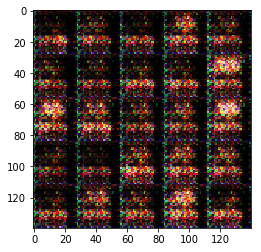

Epoch: 0/1, Discriminator Loss: 1.5260, Generator Loss: 0.5417
Epoch: 0/1, Discriminator Loss: 1.3432, Generator Loss: 0.8461
Epoch: 0/1, Discriminator Loss: 1.1536, Generator Loss: 0.8715
Epoch: 0/1, Discriminator Loss: 0.9660, Generator Loss: 1.2006
Epoch: 0/1, Discriminator Loss: 0.9914, Generator Loss: 0.9298
Epoch: 0/1, Discriminator Loss: 1.5065, Generator Loss: 0.5176
Epoch: 0/1, Discriminator Loss: 0.9209, Generator Loss: 1.5775
Epoch: 0/1, Discriminator Loss: 1.2977, Generator Loss: 0.6322
Epoch: 0/1, Discriminator Loss: 1.0451, Generator Loss: 1.5386
Epoch: 0/1, Discriminator Loss: 1.4239, Generator Loss: 0.6270


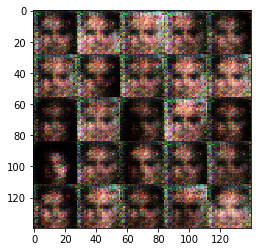

Epoch: 0/1, Discriminator Loss: 1.2152, Generator Loss: 0.8064
Epoch: 0/1, Discriminator Loss: 1.2384, Generator Loss: 0.5474
Epoch: 0/1, Discriminator Loss: 1.1407, Generator Loss: 1.0977
Epoch: 0/1, Discriminator Loss: 1.8383, Generator Loss: 0.6349
Epoch: 0/1, Discriminator Loss: 1.1691, Generator Loss: 0.6036
Epoch: 0/1, Discriminator Loss: 1.8344, Generator Loss: 0.3540
Epoch: 0/1, Discriminator Loss: 0.9669, Generator Loss: 0.8563
Epoch: 0/1, Discriminator Loss: 1.1424, Generator Loss: 1.0100
Epoch: 0/1, Discriminator Loss: 1.7077, Generator Loss: 0.3154
Epoch: 0/1, Discriminator Loss: 1.0380, Generator Loss: 0.8546


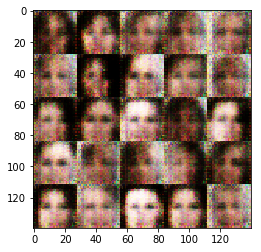

Epoch: 0/1, Discriminator Loss: 1.0012, Generator Loss: 2.3381
Epoch: 0/1, Discriminator Loss: 0.7134, Generator Loss: 3.0137
Epoch: 0/1, Discriminator Loss: 0.7701, Generator Loss: 1.3337
Epoch: 0/1, Discriminator Loss: 1.2575, Generator Loss: 0.4768
Epoch: 0/1, Discriminator Loss: 1.3402, Generator Loss: 0.6306
Epoch: 0/1, Discriminator Loss: 0.5630, Generator Loss: 3.5360
Epoch: 0/1, Discriminator Loss: 1.3358, Generator Loss: 2.9656
Epoch: 0/1, Discriminator Loss: 0.6905, Generator Loss: 1.6832
Epoch: 0/1, Discriminator Loss: 1.0488, Generator Loss: 1.8256
Epoch: 0/1, Discriminator Loss: 1.4887, Generator Loss: 0.4944


Epoch: 0/1, Discriminator Loss: 0.6455, Generator Loss: 1.5755
Epoch: 0/1, Discriminator Loss: 1.4419, Generator Loss: 0.4533
Epoch: 0/1, Discriminator Loss: 0.8521, Generator Loss: 1.6509
Epoch: 0/1, Discriminator Loss: 0.7816, Generator Loss: 1.0967
Epoch: 0/1, Discriminator Loss: 1.3125, Generator Loss: 1.3865
Epoch: 0/1, Discriminator Loss: 1.4424, Generator Loss: 0.7273
Epoch: 0/1, Discriminator Loss: 1.1290, Generator Loss: 0.8163
Epoch: 0/1, Discriminator Loss: 1.1250, Generator Loss: 0.7445
Epoch: 0/1, Discriminator Loss: 1.1341, Generator Loss: 0.6489
Epoch: 0/1, Discriminator Loss: 0.6913, Generator Loss: 1.2005


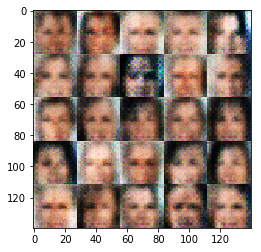

Epoch: 0/1, Discriminator Loss: 0.7752, Generator Loss: 1.1931
Epoch: 0/1, Discriminator Loss: 1.1753, Generator Loss: 1.0592
Epoch: 0/1, Discriminator Loss: 0.9533, Generator Loss: 1.6776
Epoch: 0/1, Discriminator Loss: 1.4612, Generator Loss: 0.5633
Epoch: 0/1, Discriminator Loss: 1.8552, Generator Loss: 0.2486
Epoch: 0/1, Discriminator Loss: 1.2770, Generator Loss: 0.8985
Epoch: 0/1, Discriminator Loss: 1.4390, Generator Loss: 0.4972
Epoch: 0/1, Discriminator Loss: 1.1199, Generator Loss: 0.8159
Epoch: 0/1, Discriminator Loss: 1.4958, Generator Loss: 0.7133
Epoch: 0/1, Discriminator Loss: 1.3828, Generator Loss: 0.5840


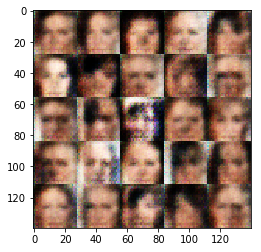

Epoch: 0/1, Discriminator Loss: 1.3724, Generator Loss: 0.4677
Epoch: 0/1, Discriminator Loss: 0.9124, Generator Loss: 0.8774
Epoch: 0/1, Discriminator Loss: 2.3980, Generator Loss: 0.1480
Epoch: 0/1, Discriminator Loss: 0.9614, Generator Loss: 0.9035
Epoch: 0/1, Discriminator Loss: 1.1192, Generator Loss: 0.6964
Epoch: 0/1, Discriminator Loss: 1.3640, Generator Loss: 0.7765
Epoch: 0/1, Discriminator Loss: 1.4002, Generator Loss: 0.7614
Epoch: 0/1, Discriminator Loss: 1.4556, Generator Loss: 0.6482
Epoch: 0/1, Discriminator Loss: 1.6140, Generator Loss: 0.3968
Epoch: 0/1, Discriminator Loss: 1.2651, Generator Loss: 0.6481


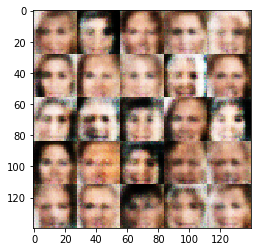

Epoch: 0/1, Discriminator Loss: 1.1327, Generator Loss: 0.7847
Epoch: 0/1, Discriminator Loss: 0.6645, Generator Loss: 2.2055
Epoch: 0/1, Discriminator Loss: 1.1114, Generator Loss: 1.2046
Epoch: 0/1, Discriminator Loss: 1.7184, Generator Loss: 0.3094
Epoch: 0/1, Discriminator Loss: 1.2017, Generator Loss: 0.8968
Epoch: 0/1, Discriminator Loss: 1.1009, Generator Loss: 0.7943
Epoch: 0/1, Discriminator Loss: 0.9212, Generator Loss: 1.1695
Epoch: 0/1, Discriminator Loss: 1.5070, Generator Loss: 0.6870
Epoch: 0/1, Discriminator Loss: 1.4707, Generator Loss: 0.7504
Epoch: 0/1, Discriminator Loss: 1.3380, Generator Loss: 0.5672


Epoch: 0/1, Discriminator Loss: 1.2794, Generator Loss: 0.5173
Epoch: 0/1, Discriminator Loss: 1.3321, Generator Loss: 1.0510
Epoch: 0/1, Discriminator Loss: 1.1731, Generator Loss: 0.9188
Epoch: 0/1, Discriminator Loss: 1.0539, Generator Loss: 1.2162
Epoch: 0/1, Discriminator Loss: 1.1108, Generator Loss: 1.0636
Epoch: 0/1, Discriminator Loss: 0.9350, Generator Loss: 1.8886
Epoch: 0/1, Discriminator Loss: 1.4475, Generator Loss: 0.6356
Epoch: 0/1, Discriminator Loss: 2.0484, Generator Loss: 0.1925
Epoch: 0/1, Discriminator Loss: 1.0476, Generator Loss: 1.1894
Epoch: 0/1, Discriminator Loss: 1.3225, Generator Loss: 0.6228


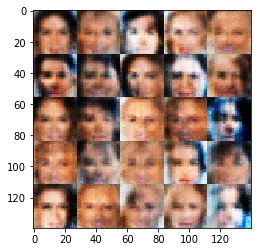

Epoch: 0/1, Discriminator Loss: 1.2567, Generator Loss: 1.2340
Epoch: 0/1, Discriminator Loss: 0.8894, Generator Loss: 1.5045
Epoch: 0/1, Discriminator Loss: 0.8293, Generator Loss: 1.8032
Epoch: 0/1, Discriminator Loss: 1.0668, Generator Loss: 0.5712
Epoch: 0/1, Discriminator Loss: 0.8949, Generator Loss: 1.0098
Epoch: 0/1, Discriminator Loss: 0.6531, Generator Loss: 2.5700
Epoch: 0/1, Discriminator Loss: 1.6638, Generator Loss: 0.3524
Epoch: 0/1, Discriminator Loss: 1.1198, Generator Loss: 1.1703
Epoch: 0/1, Discriminator Loss: 1.5088, Generator Loss: 0.5999
Epoch: 0/1, Discriminator Loss: 1.2686, Generator Loss: 0.5258


Epoch: 0/1, Discriminator Loss: 0.9120, Generator Loss: 0.8936
Epoch: 0/1, Discriminator Loss: 1.2790, Generator Loss: 1.3464
Epoch: 0/1, Discriminator Loss: 0.8471, Generator Loss: 1.1530
Epoch: 0/1, Discriminator Loss: 0.9957, Generator Loss: 1.9322
Epoch: 0/1, Discriminator Loss: 0.7879, Generator Loss: 1.6496
Epoch: 0/1, Discriminator Loss: 1.0252, Generator Loss: 1.4812
Epoch: 0/1, Discriminator Loss: 1.0347, Generator Loss: 0.7577
Epoch: 0/1, Discriminator Loss: 0.7986, Generator Loss: 1.2684
Epoch: 0/1, Discriminator Loss: 0.8910, Generator Loss: 0.7562
Epoch: 0/1, Discriminator Loss: 1.1114, Generator Loss: 3.8755


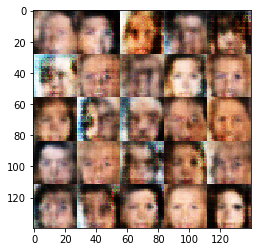

Epoch: 0/1, Discriminator Loss: 0.9962, Generator Loss: 1.5880
Epoch: 0/1, Discriminator Loss: 0.9285, Generator Loss: 0.8239
Epoch: 0/1, Discriminator Loss: 0.8990, Generator Loss: 2.2139
Epoch: 0/1, Discriminator Loss: 0.8910, Generator Loss: 1.8421
Epoch: 0/1, Discriminator Loss: 0.5767, Generator Loss: 1.8340
Epoch: 0/1, Discriminator Loss: 0.5591, Generator Loss: 2.7694
Epoch: 0/1, Discriminator Loss: 2.1280, Generator Loss: 0.1927
Epoch: 0/1, Discriminator Loss: 1.4899, Generator Loss: 0.7812
Epoch: 0/1, Discriminator Loss: 0.5693, Generator Loss: 1.7765
Epoch: 0/1, Discriminator Loss: 1.7680, Generator Loss: 0.2958


Epoch: 0/1, Discriminator Loss: 1.7403, Generator Loss: 0.3565
Epoch: 0/1, Discriminator Loss: 1.4585, Generator Loss: 0.5435
Epoch: 0/1, Discriminator Loss: 1.1842, Generator Loss: 0.5452
Epoch: 0/1, Discriminator Loss: 0.9400, Generator Loss: 0.7845
Epoch: 0/1, Discriminator Loss: 1.2883, Generator Loss: 0.6197
Epoch: 0/1, Discriminator Loss: 1.5660, Generator Loss: 0.3288
Epoch: 0/1, Discriminator Loss: 0.8671, Generator Loss: 1.6156
Epoch: 0/1, Discriminator Loss: 1.3073, Generator Loss: 0.5022
Epoch: 0/1, Discriminator Loss: 1.2413, Generator Loss: 1.8068
Epoch: 0/1, Discriminator Loss: 0.9855, Generator Loss: 0.8014


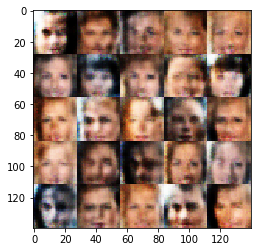

Epoch: 0/1, Discriminator Loss: 0.8399, Generator Loss: 1.7241
Epoch: 0/1, Discriminator Loss: 1.3633, Generator Loss: 0.4626
Epoch: 0/1, Discriminator Loss: 0.8798, Generator Loss: 0.8308
Epoch: 0/1, Discriminator Loss: 0.9776, Generator Loss: 1.5701
Epoch: 0/1, Discriminator Loss: 1.2815, Generator Loss: 1.0399
Epoch: 0/1, Discriminator Loss: 1.7955, Generator Loss: 0.3278
Epoch: 0/1, Discriminator Loss: 1.1739, Generator Loss: 0.7652
Epoch: 0/1, Discriminator Loss: 1.4722, Generator Loss: 0.5415
Epoch: 0/1, Discriminator Loss: 1.5111, Generator Loss: 1.2517
Epoch: 0/1, Discriminator Loss: 1.2352, Generator Loss: 0.6836


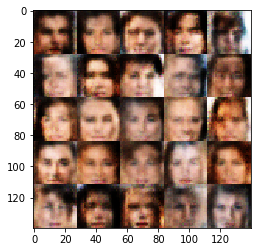

Epoch: 0/1, Discriminator Loss: 1.0320, Generator Loss: 0.9867
Epoch: 0/1, Discriminator Loss: 0.5747, Generator Loss: 1.5655
Epoch: 0/1, Discriminator Loss: 1.8212, Generator Loss: 0.4701
Epoch: 0/1, Discriminator Loss: 1.4421, Generator Loss: 0.5244
Epoch: 0/1, Discriminator Loss: 1.4969, Generator Loss: 0.4721
Epoch: 0/1, Discriminator Loss: 1.6439, Generator Loss: 0.3539
Epoch: 0/1, Discriminator Loss: 1.4276, Generator Loss: 0.4412
Epoch: 0/1, Discriminator Loss: 0.4773, Generator Loss: 1.7618
Epoch: 0/1, Discriminator Loss: 1.1398, Generator Loss: 0.8945
Epoch: 0/1, Discriminator Loss: 0.9705, Generator Loss: 1.4039


Epoch: 0/1, Discriminator Loss: 1.1349, Generator Loss: 0.5756
Epoch: 0/1, Discriminator Loss: 1.3517, Generator Loss: 0.9014
Epoch: 0/1, Discriminator Loss: 1.0910, Generator Loss: 1.0809
Epoch: 0/1, Discriminator Loss: 1.0311, Generator Loss: 0.8591
Epoch: 0/1, Discriminator Loss: 1.1376, Generator Loss: 1.7871
Epoch: 0/1, Discriminator Loss: 1.3575, Generator Loss: 0.4966
Epoch: 0/1, Discriminator Loss: 1.2173, Generator Loss: 0.8038
Epoch: 0/1, Discriminator Loss: 1.4971, Generator Loss: 0.6250
Epoch: 0/1, Discriminator Loss: 1.6755, Generator Loss: 0.5948
Epoch: 0/1, Discriminator Loss: 1.4415, Generator Loss: 0.5530


Epoch: 0/1, Discriminator Loss: 1.3163, Generator Loss: 0.7908
Epoch: 0/1, Discriminator Loss: 1.4734, Generator Loss: 0.7425
Epoch: 0/1, Discriminator Loss: 1.5034, Generator Loss: 0.4031
Epoch: 0/1, Discriminator Loss: 1.0319, Generator Loss: 1.0253
Epoch: 0/1, Discriminator Loss: 1.2181, Generator Loss: 0.5919
Epoch: 0/1, Discriminator Loss: 1.0573, Generator Loss: 0.8505
Epoch: 0/1, Discriminator Loss: 0.8090, Generator Loss: 1.4787
Epoch: 0/1, Discriminator Loss: 1.2270, Generator Loss: 1.0989
Epoch: 0/1, Discriminator Loss: 0.8569, Generator Loss: 1.4272
Epoch: 0/1, Discriminator Loss: 1.3025, Generator Loss: 0.5070


Epoch: 0/1, Discriminator Loss: 2.0993, Generator Loss: 0.1801
Epoch: 0/1, Discriminator Loss: 1.6877, Generator Loss: 0.2883
Epoch: 0/1, Discriminator Loss: 1.0758, Generator Loss: 0.9486
Epoch: 0/1, Discriminator Loss: 1.5632, Generator Loss: 0.4637
Epoch: 0/1, Discriminator Loss: 1.3680, Generator Loss: 0.6469
Epoch: 0/1, Discriminator Loss: 1.4671, Generator Loss: 0.4013
Epoch: 0/1, Discriminator Loss: 1.1303, Generator Loss: 0.7274
Epoch: 0/1, Discriminator Loss: 1.4043, Generator Loss: 0.7317
Epoch: 0/1, Discriminator Loss: 1.3042, Generator Loss: 1.3476
Epoch: 0/1, Discriminator Loss: 1.3237, Generator Loss: 0.6549


Epoch: 0/1, Discriminator Loss: 1.2756, Generator Loss: 0.6423
Epoch: 0/1, Discriminator Loss: 1.2704, Generator Loss: 0.9068
Epoch: 0/1, Discriminator Loss: 1.1048, Generator Loss: 1.3923
Epoch: 0/1, Discriminator Loss: 1.1633, Generator Loss: 1.1835
Epoch: 0/1, Discriminator Loss: 1.1771, Generator Loss: 0.5215
Epoch: 0/1, Discriminator Loss: 1.1508, Generator Loss: 1.1018
Epoch: 0/1, Discriminator Loss: 1.0252, Generator Loss: 0.9378
Epoch: 0/1, Discriminator Loss: 1.5025, Generator Loss: 0.5935
Epoch: 0/1, Discriminator Loss: 1.3767, Generator Loss: 0.4749
Epoch: 0/1, Discriminator Loss: 1.0397, Generator Loss: 0.9166


Epoch: 0/1, Discriminator Loss: 1.2908, Generator Loss: 0.7276
Epoch: 0/1, Discriminator Loss: 1.1131, Generator Loss: 1.4886
Epoch: 0/1, Discriminator Loss: 0.7184, Generator Loss: 1.1794
Epoch: 0/1, Discriminator Loss: 1.1120, Generator Loss: 0.8594
Epoch: 0/1, Discriminator Loss: 1.9015, Generator Loss: 0.2384
Epoch: 0/1, Discriminator Loss: 1.0871, Generator Loss: 0.6363
Epoch: 0/1, Discriminator Loss: 1.2727, Generator Loss: 0.7259
Epoch: 0/1, Discriminator Loss: 1.5987, Generator Loss: 0.3981
Epoch: 0/1, Discriminator Loss: 0.9637, Generator Loss: 0.7457
Epoch: 0/1, Discriminator Loss: 1.0049, Generator Loss: 1.0614


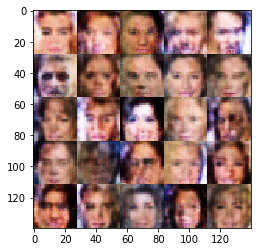

Epoch: 0/1, Discriminator Loss: 1.0642, Generator Loss: 0.9084
Epoch: 0/1, Discriminator Loss: 1.4598, Generator Loss: 0.3960
Epoch: 0/1, Discriminator Loss: 1.1923, Generator Loss: 0.7602
Epoch: 0/1, Discriminator Loss: 1.3379, Generator Loss: 0.7379
Epoch: 0/1, Discriminator Loss: 0.9877, Generator Loss: 0.9519
Epoch: 0/1, Discriminator Loss: 1.4253, Generator Loss: 0.6127
Epoch: 0/1, Discriminator Loss: 0.9810, Generator Loss: 0.7706
Epoch: 0/1, Discriminator Loss: 0.8831, Generator Loss: 1.6614
Epoch: 0/1, Discriminator Loss: 1.3222, Generator Loss: 0.6951
Epoch: 0/1, Discriminator Loss: 1.2704, Generator Loss: 0.8843


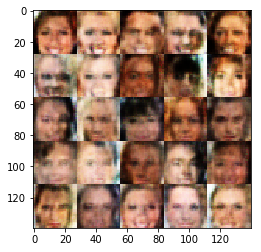

Epoch: 0/1, Discriminator Loss: 1.2335, Generator Loss: 0.9320
Epoch: 0/1, Discriminator Loss: 0.9334, Generator Loss: 1.3362
Epoch: 0/1, Discriminator Loss: 1.5399, Generator Loss: 0.5755
Epoch: 0/1, Discriminator Loss: 1.3925, Generator Loss: 0.4886
Epoch: 0/1, Discriminator Loss: 1.0409, Generator Loss: 1.1956
Epoch: 0/1, Discriminator Loss: 1.1723, Generator Loss: 0.6537
Epoch: 0/1, Discriminator Loss: 1.2624, Generator Loss: 0.7395
Epoch: 0/1, Discriminator Loss: 1.1763, Generator Loss: 1.1784
Epoch: 0/1, Discriminator Loss: 1.2637, Generator Loss: 0.5754
Epoch: 0/1, Discriminator Loss: 1.4577, Generator Loss: 0.7309


Epoch: 0/1, Discriminator Loss: 1.3983, Generator Loss: 0.5499
Epoch: 0/1, Discriminator Loss: 1.1302, Generator Loss: 0.6797
Epoch: 0/1, Discriminator Loss: 0.8513, Generator Loss: 1.2414
Epoch: 0/1, Discriminator Loss: 1.0489, Generator Loss: 0.7328
Epoch: 0/1, Discriminator Loss: 1.2513, Generator Loss: 0.6769
Epoch: 0/1, Discriminator Loss: 1.4123, Generator Loss: 0.8044
Epoch: 0/1, Discriminator Loss: 1.3530, Generator Loss: 0.8434
Epoch: 0/1, Discriminator Loss: 1.1130, Generator Loss: 0.6320
Epoch: 0/1, Discriminator Loss: 1.9377, Generator Loss: 0.2105
Epoch: 0/1, Discriminator Loss: 1.7209, Generator Loss: 0.2773


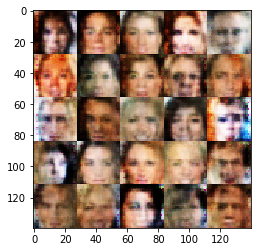

Epoch: 0/1, Discriminator Loss: 0.7731, Generator Loss: 1.3089
Epoch: 0/1, Discriminator Loss: 0.7760, Generator Loss: 1.4796
Epoch: 0/1, Discriminator Loss: 1.1579, Generator Loss: 1.1120
Epoch: 0/1, Discriminator Loss: 1.1693, Generator Loss: 0.6572
Epoch: 0/1, Discriminator Loss: 1.3670, Generator Loss: 0.7812
Epoch: 0/1, Discriminator Loss: 0.9987, Generator Loss: 1.0588
Epoch: 0/1, Discriminator Loss: 1.0629, Generator Loss: 0.5878
Epoch: 0/1, Discriminator Loss: 0.7192, Generator Loss: 1.5451
Epoch: 0/1, Discriminator Loss: 0.7246, Generator Loss: 1.8065
Epoch: 0/1, Discriminator Loss: 1.6586, Generator Loss: 0.5416


Epoch: 0/1, Discriminator Loss: 1.2222, Generator Loss: 1.6491
Epoch: 0/1, Discriminator Loss: 1.0178, Generator Loss: 0.9739
Epoch: 0/1, Discriminator Loss: 1.2756, Generator Loss: 0.6047
Epoch: 0/1, Discriminator Loss: 1.0271, Generator Loss: 1.1221
Epoch: 0/1, Discriminator Loss: 0.9042, Generator Loss: 1.1730
Epoch: 0/1, Discriminator Loss: 1.4449, Generator Loss: 0.6055
Epoch: 0/1, Discriminator Loss: 1.5505, Generator Loss: 0.3773
Epoch: 0/1, Discriminator Loss: 0.9519, Generator Loss: 0.9897
Epoch: 0/1, Discriminator Loss: 0.7811, Generator Loss: 1.1252
Epoch: 0/1, Discriminator Loss: 1.1939, Generator Loss: 1.0341


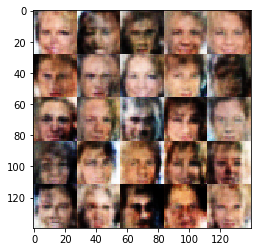

Epoch: 0/1, Discriminator Loss: 0.8623, Generator Loss: 1.5428
Epoch: 0/1, Discriminator Loss: 1.4627, Generator Loss: 0.6324
Epoch: 0/1, Discriminator Loss: 1.8209, Generator Loss: 0.2428
Epoch: 0/1, Discriminator Loss: 1.4452, Generator Loss: 0.4040
Epoch: 0/1, Discriminator Loss: 1.0059, Generator Loss: 1.0796
Epoch: 0/1, Discriminator Loss: 1.5138, Generator Loss: 0.3637
Epoch: 0/1, Discriminator Loss: 0.9442, Generator Loss: 1.3444
Epoch: 0/1, Discriminator Loss: 1.5017, Generator Loss: 0.5163
Epoch: 0/1, Discriminator Loss: 0.9210, Generator Loss: 1.5554
Epoch: 0/1, Discriminator Loss: 0.9280, Generator Loss: 0.7424


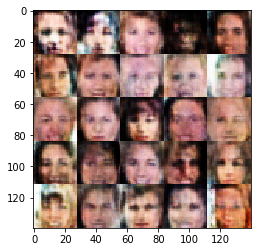

Epoch: 0/1, Discriminator Loss: 1.5464, Generator Loss: 0.5204
Epoch: 0/1, Discriminator Loss: 2.0336, Generator Loss: 0.1861
Epoch: 0/1, Discriminator Loss: 1.3327, Generator Loss: 0.5945
Epoch: 0/1, Discriminator Loss: 1.1870, Generator Loss: 0.7011
Epoch: 0/1, Discriminator Loss: 1.2133, Generator Loss: 0.6961
Epoch: 0/1, Discriminator Loss: 0.8100, Generator Loss: 1.8034
Epoch: 0/1, Discriminator Loss: 1.9426, Generator Loss: 0.2237
Epoch: 0/1, Discriminator Loss: 1.0566, Generator Loss: 1.9986
Epoch: 0/1, Discriminator Loss: 1.0605, Generator Loss: 1.1134
Epoch: 0/1, Discriminator Loss: 1.5191, Generator Loss: 0.4297


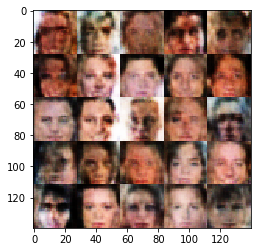

Epoch: 0/1, Discriminator Loss: 1.5416, Generator Loss: 0.3787
Epoch: 0/1, Discriminator Loss: 1.2312, Generator Loss: 0.9845
Epoch: 0/1, Discriminator Loss: 0.6050, Generator Loss: 2.0460
Epoch: 0/1, Discriminator Loss: 1.0888, Generator Loss: 0.6753
Epoch: 0/1, Discriminator Loss: 1.1228, Generator Loss: 0.8921
Epoch: 0/1, Discriminator Loss: 1.1514, Generator Loss: 2.3651
Epoch: 0/1, Discriminator Loss: 0.8428, Generator Loss: 0.8548
Epoch: 0/1, Discriminator Loss: 1.4167, Generator Loss: 0.6385
Epoch: 0/1, Discriminator Loss: 1.5109, Generator Loss: 0.8596
Epoch: 0/1, Discriminator Loss: 1.4225, Generator Loss: 0.6723


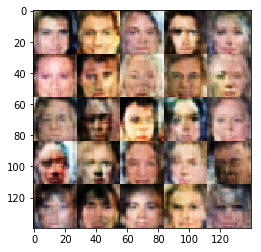

Epoch: 0/1, Discriminator Loss: 1.4270, Generator Loss: 0.7122
Epoch: 0/1, Discriminator Loss: 1.2807, Generator Loss: 1.1353
Epoch: 0/1, Discriminator Loss: 1.4412, Generator Loss: 0.4229
Epoch: 0/1, Discriminator Loss: 1.2496, Generator Loss: 0.9410
Epoch: 0/1, Discriminator Loss: 1.2228, Generator Loss: 0.5393
Epoch: 0/1, Discriminator Loss: 1.4310, Generator Loss: 0.4756
Epoch: 0/1, Discriminator Loss: 1.2135, Generator Loss: 0.9482
Epoch: 0/1, Discriminator Loss: 1.0842, Generator Loss: 0.7753
Epoch: 0/1, Discriminator Loss: 1.4572, Generator Loss: 0.6035
Epoch: 0/1, Discriminator Loss: 1.5119, Generator Loss: 0.5895


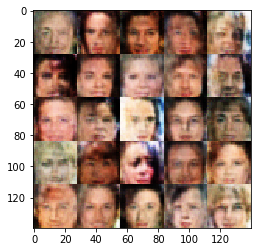

Epoch: 0/1, Discriminator Loss: 0.6983, Generator Loss: 2.0559
Epoch: 0/1, Discriminator Loss: 1.2728, Generator Loss: 0.7932
Epoch: 0/1, Discriminator Loss: 1.4055, Generator Loss: 0.8704
Epoch: 0/1, Discriminator Loss: 1.0975, Generator Loss: 0.5880
Epoch: 0/1, Discriminator Loss: 1.6039, Generator Loss: 0.3870
Epoch: 0/1, Discriminator Loss: 1.2677, Generator Loss: 0.8056
Epoch: 0/1, Discriminator Loss: 1.1279, Generator Loss: 0.7670
Epoch: 0/1, Discriminator Loss: 1.4863, Generator Loss: 0.5896
Epoch: 0/1, Discriminator Loss: 0.9495, Generator Loss: 1.1038
Epoch: 0/1, Discriminator Loss: 0.9480, Generator Loss: 1.0628


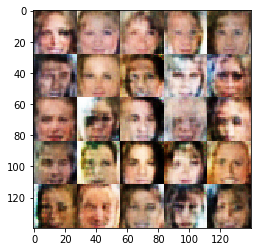

Epoch: 0/1, Discriminator Loss: 1.0306, Generator Loss: 0.8661
Epoch: 0/1, Discriminator Loss: 1.3162, Generator Loss: 0.5944
Epoch: 0/1, Discriminator Loss: 1.3629, Generator Loss: 0.4509
Epoch: 0/1, Discriminator Loss: 1.0758, Generator Loss: 0.6914
Epoch: 0/1, Discriminator Loss: 0.9324, Generator Loss: 1.2619
Epoch: 0/1, Discriminator Loss: 1.5347, Generator Loss: 0.5598
Epoch: 0/1, Discriminator Loss: 1.2232, Generator Loss: 1.9581
Epoch: 0/1, Discriminator Loss: 1.1888, Generator Loss: 0.5585
Epoch: 0/1, Discriminator Loss: 1.2643, Generator Loss: 0.5828
Epoch: 0/1, Discriminator Loss: 1.2181, Generator Loss: 0.8955


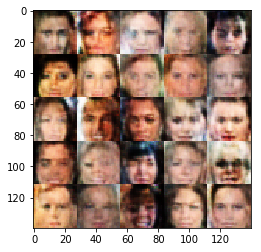

Epoch: 0/1, Discriminator Loss: 1.5524, Generator Loss: 0.4955
Epoch: 0/1, Discriminator Loss: 1.4460, Generator Loss: 0.3676
Epoch: 0/1, Discriminator Loss: 0.7997, Generator Loss: 1.4833
Epoch: 0/1, Discriminator Loss: 0.8168, Generator Loss: 1.1172
Epoch: 0/1, Discriminator Loss: 0.8097, Generator Loss: 1.6717
Epoch: 0/1, Discriminator Loss: 1.5792, Generator Loss: 0.5449
Epoch: 0/1, Discriminator Loss: 1.2384, Generator Loss: 0.9679
Epoch: 0/1, Discriminator Loss: 0.9626, Generator Loss: 1.7163
Epoch: 0/1, Discriminator Loss: 1.6332, Generator Loss: 0.4847
Epoch: 0/1, Discriminator Loss: 1.6505, Generator Loss: 0.2998


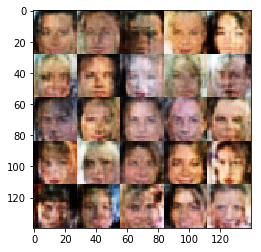

Epoch: 0/1, Discriminator Loss: 0.6601, Generator Loss: 1.8166
Epoch: 0/1, Discriminator Loss: 1.1991, Generator Loss: 0.8391
Epoch: 0/1, Discriminator Loss: 1.4635, Generator Loss: 0.6772
Epoch: 0/1, Discriminator Loss: 1.2002, Generator Loss: 0.6805
Epoch: 0/1, Discriminator Loss: 1.3033, Generator Loss: 1.1203
Epoch: 0/1, Discriminator Loss: 1.0566, Generator Loss: 0.8280
Epoch: 0/1, Discriminator Loss: 1.3438, Generator Loss: 0.5315
Epoch: 0/1, Discriminator Loss: 1.4488, Generator Loss: 0.4551
Epoch: 0/1, Discriminator Loss: 0.8918, Generator Loss: 0.8131
Epoch: 0/1, Discriminator Loss: 1.5186, Generator Loss: 0.4390


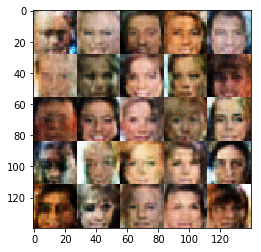

Epoch: 0/1, Discriminator Loss: 1.4521, Generator Loss: 0.6760
Epoch: 0/1, Discriminator Loss: 1.9978, Generator Loss: 0.2123
Epoch: 0/1, Discriminator Loss: 1.4079, Generator Loss: 0.5334
Epoch: 0/1, Discriminator Loss: 1.1954, Generator Loss: 0.7967
Epoch: 0/1, Discriminator Loss: 1.5787, Generator Loss: 0.3512
Epoch: 0/1, Discriminator Loss: 1.3778, Generator Loss: 0.7049
Epoch: 0/1, Discriminator Loss: 1.5120, Generator Loss: 0.5366
Epoch: 0/1, Discriminator Loss: 1.2060, Generator Loss: 0.9635
Epoch: 0/1, Discriminator Loss: 1.4831, Generator Loss: 0.4702
Epoch: 0/1, Discriminator Loss: 1.6778, Generator Loss: 0.3178


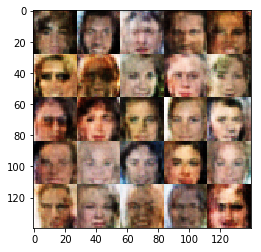

Epoch: 0/1, Discriminator Loss: 1.2808, Generator Loss: 0.4558
Epoch: 0/1, Discriminator Loss: 1.3766, Generator Loss: 0.5815
Epoch: 0/1, Discriminator Loss: 0.9693, Generator Loss: 2.3664
Epoch: 0/1, Discriminator Loss: 1.2686, Generator Loss: 0.9689
Epoch: 0/1, Discriminator Loss: 1.3093, Generator Loss: 0.5005
Epoch: 0/1, Discriminator Loss: 1.2769, Generator Loss: 0.7740
Epoch: 0/1, Discriminator Loss: 1.0023, Generator Loss: 1.0897
Epoch: 0/1, Discriminator Loss: 1.4307, Generator Loss: 0.6985
Epoch: 0/1, Discriminator Loss: 1.6838, Generator Loss: 0.3064
Epoch: 0/1, Discriminator Loss: 1.2980, Generator Loss: 0.6072


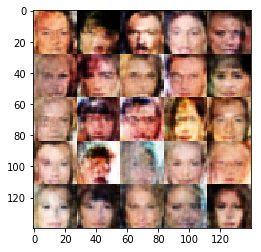

Epoch: 0/1, Discriminator Loss: 1.2139, Generator Loss: 0.8901
Epoch: 0/1, Discriminator Loss: 1.0247, Generator Loss: 1.3513
Epoch: 0/1, Discriminator Loss: 1.1818, Generator Loss: 0.8612
Epoch: 0/1, Discriminator Loss: 1.2008, Generator Loss: 0.8270
Epoch: 0/1, Discriminator Loss: 1.0399, Generator Loss: 1.6370
Epoch: 0/1, Discriminator Loss: 1.3627, Generator Loss: 0.5682
Epoch: 0/1, Discriminator Loss: 1.0451, Generator Loss: 1.2028
Epoch: 0/1, Discriminator Loss: 0.9543, Generator Loss: 0.8859
Epoch: 0/1, Discriminator Loss: 0.9643, Generator Loss: 1.5913
Epoch: 0/1, Discriminator Loss: 1.4805, Generator Loss: 0.3669


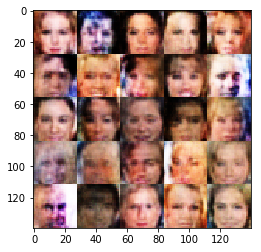

Epoch: 0/1, Discriminator Loss: 1.2443, Generator Loss: 0.7752
Epoch: 0/1, Discriminator Loss: 1.2790, Generator Loss: 0.5899
Epoch: 0/1, Discriminator Loss: 1.2098, Generator Loss: 0.7834
Epoch: 0/1, Discriminator Loss: 1.0097, Generator Loss: 1.0880
Epoch: 0/1, Discriminator Loss: 1.1647, Generator Loss: 0.8980
Epoch: 0/1, Discriminator Loss: 1.7570, Generator Loss: 0.3171
Epoch: 0/1, Discriminator Loss: 0.9695, Generator Loss: 0.8528
Epoch: 0/1, Discriminator Loss: 1.7555, Generator Loss: 0.2418
Epoch: 0/1, Discriminator Loss: 0.4606, Generator Loss: 3.3743
Epoch: 0/1, Discriminator Loss: 1.3200, Generator Loss: 0.7697


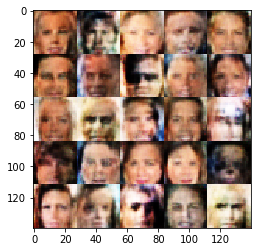

Epoch: 0/1, Discriminator Loss: 0.9953, Generator Loss: 0.9292
Epoch: 0/1, Discriminator Loss: 1.0924, Generator Loss: 0.6291
Epoch: 0/1, Discriminator Loss: 1.7454, Generator Loss: 0.2509
Epoch: 0/1, Discriminator Loss: 1.0884, Generator Loss: 0.8980
Epoch: 0/1, Discriminator Loss: 1.1883, Generator Loss: 0.7908
Epoch: 0/1, Discriminator Loss: 1.5084, Generator Loss: 0.3983
Epoch: 0/1, Discriminator Loss: 1.2881, Generator Loss: 0.4522
Epoch: 0/1, Discriminator Loss: 1.0646, Generator Loss: 0.9670
Epoch: 0/1, Discriminator Loss: 1.4457, Generator Loss: 0.4180
Epoch: 0/1, Discriminator Loss: 1.2504, Generator Loss: 0.7907


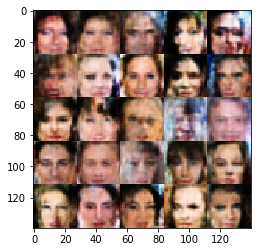

Epoch: 0/1, Discriminator Loss: 1.1289, Generator Loss: 0.6989
Epoch: 0/1, Discriminator Loss: 1.2559, Generator Loss: 0.8274
Epoch: 0/1, Discriminator Loss: 0.9271, Generator Loss: 1.1340
Epoch: 0/1, Discriminator Loss: 1.3589, Generator Loss: 1.0547
Epoch: 0/1, Discriminator Loss: 0.8577, Generator Loss: 1.2957
Epoch: 0/1, Discriminator Loss: 1.6184, Generator Loss: 0.3629
Epoch: 0/1, Discriminator Loss: 1.3947, Generator Loss: 0.4104
Epoch: 0/1, Discriminator Loss: 1.0982, Generator Loss: 0.7975
Epoch: 0/1, Discriminator Loss: 1.0513, Generator Loss: 1.3657
Epoch: 0/1, Discriminator Loss: 1.5827, Generator Loss: 0.3109


Epoch: 0/1, Discriminator Loss: 1.4047, Generator Loss: 0.5189
Epoch: 0/1, Discriminator Loss: 1.3907, Generator Loss: 0.4761
Epoch: 0/1, Discriminator Loss: 1.2607, Generator Loss: 0.7793
Epoch: 0/1, Discriminator Loss: 1.3099, Generator Loss: 0.7253
Epoch: 0/1, Discriminator Loss: 1.4220, Generator Loss: 0.6602
Epoch: 0/1, Discriminator Loss: 1.3295, Generator Loss: 0.6281
Epoch: 0/1, Discriminator Loss: 1.5639, Generator Loss: 0.3216
Epoch: 0/1, Discriminator Loss: 1.7156, Generator Loss: 0.3544
Epoch: 0/1, Discriminator Loss: 1.1494, Generator Loss: 0.8037
Epoch: 0/1, Discriminator Loss: 1.0990, Generator Loss: 0.8391


Epoch: 0/1, Discriminator Loss: 1.2829, Generator Loss: 0.7389
Epoch: 0/1, Discriminator Loss: 1.1157, Generator Loss: 1.0672
Epoch: 0/1, Discriminator Loss: 1.3465, Generator Loss: 0.6247
Epoch: 0/1, Discriminator Loss: 1.1229, Generator Loss: 1.3036
Epoch: 0/1, Discriminator Loss: 0.6827, Generator Loss: 1.4472
Epoch: 0/1, Discriminator Loss: 1.1342, Generator Loss: 1.0827
Epoch: 0/1, Discriminator Loss: 1.1115, Generator Loss: 0.9567
Epoch: 0/1, Discriminator Loss: 1.4102, Generator Loss: 0.6403
Epoch: 0/1, Discriminator Loss: 1.3801, Generator Loss: 0.7440
Epoch: 0/1, Discriminator Loss: 0.8285, Generator Loss: 1.0473


Epoch: 0/1, Discriminator Loss: 0.7908, Generator Loss: 1.3793
Epoch: 0/1, Discriminator Loss: 1.0520, Generator Loss: 0.8281
Epoch: 0/1, Discriminator Loss: 0.8903, Generator Loss: 0.8787
Epoch: 0/1, Discriminator Loss: 0.9855, Generator Loss: 0.6664
Epoch: 0/1, Discriminator Loss: 1.1029, Generator Loss: 0.7989
Epoch: 0/1, Discriminator Loss: 1.4460, Generator Loss: 0.9723
Epoch: 0/1, Discriminator Loss: 0.8700, Generator Loss: 1.1388
Epoch: 0/1, Discriminator Loss: 0.9484, Generator Loss: 1.2627
Epoch: 0/1, Discriminator Loss: 1.0468, Generator Loss: 0.7616
Epoch: 0/1, Discriminator Loss: 1.5941, Generator Loss: 0.4644


Epoch: 0/1, Discriminator Loss: 0.8839, Generator Loss: 1.1480
Epoch: 0/1, Discriminator Loss: 1.5039, Generator Loss: 0.4093
Epoch: 0/1, Discriminator Loss: 1.7649, Generator Loss: 0.2513
Epoch: 0/1, Discriminator Loss: 1.3382, Generator Loss: 1.0169
Epoch: 0/1, Discriminator Loss: 0.9197, Generator Loss: 1.4003
Epoch: 0/1, Discriminator Loss: 1.6344, Generator Loss: 0.6033
Epoch: 0/1, Discriminator Loss: 1.4276, Generator Loss: 0.7193
Epoch: 0/1, Discriminator Loss: 0.7681, Generator Loss: 1.9424
Epoch: 0/1, Discriminator Loss: 1.3499, Generator Loss: 0.8303
Epoch: 0/1, Discriminator Loss: 1.4466, Generator Loss: 0.5853


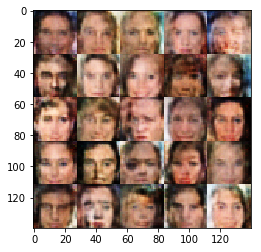

Epoch: 0/1, Discriminator Loss: 1.1936, Generator Loss: 0.7358
Epoch: 0/1, Discriminator Loss: 0.7998, Generator Loss: 2.1078
Epoch: 0/1, Discriminator Loss: 0.9767, Generator Loss: 0.8058
Epoch: 0/1, Discriminator Loss: 1.7164, Generator Loss: 0.2720
Epoch: 0/1, Discriminator Loss: 1.2750, Generator Loss: 0.8007
Epoch: 0/1, Discriminator Loss: 1.3540, Generator Loss: 0.5277
Epoch: 0/1, Discriminator Loss: 1.0211, Generator Loss: 0.8753
Epoch: 0/1, Discriminator Loss: 1.1026, Generator Loss: 0.8722
Epoch: 0/1, Discriminator Loss: 1.4428, Generator Loss: 0.9639
Epoch: 0/1, Discriminator Loss: 1.3496, Generator Loss: 0.8168


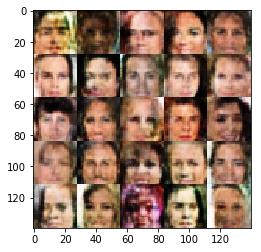

Epoch: 0/1, Discriminator Loss: 1.3832, Generator Loss: 0.5340
Epoch: 0/1, Discriminator Loss: 1.1106, Generator Loss: 0.7838
Epoch: 0/1, Discriminator Loss: 1.2628, Generator Loss: 0.6626
Epoch: 0/1, Discriminator Loss: 1.5215, Generator Loss: 0.8432
Epoch: 0/1, Discriminator Loss: 1.3999, Generator Loss: 0.4228
Epoch: 0/1, Discriminator Loss: 1.2676, Generator Loss: 0.7144
Epoch: 0/1, Discriminator Loss: 1.3859, Generator Loss: 0.4473
Epoch: 0/1, Discriminator Loss: 1.2959, Generator Loss: 0.6293
Epoch: 0/1, Discriminator Loss: 1.5765, Generator Loss: 0.4344
Epoch: 0/1, Discriminator Loss: 1.5136, Generator Loss: 0.4542


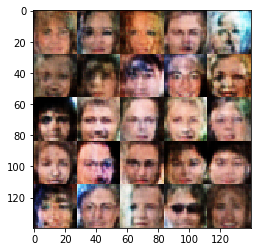

Epoch: 0/1, Discriminator Loss: 1.3012, Generator Loss: 0.8487
Epoch: 0/1, Discriminator Loss: 1.6086, Generator Loss: 0.2782
Epoch: 0/1, Discriminator Loss: 1.1000, Generator Loss: 1.1708
Epoch: 0/1, Discriminator Loss: 1.3042, Generator Loss: 0.4942
Epoch: 0/1, Discriminator Loss: 1.2283, Generator Loss: 1.0269
Epoch: 0/1, Discriminator Loss: 1.3844, Generator Loss: 0.6860
Epoch: 0/1, Discriminator Loss: 0.9808, Generator Loss: 1.6544
Epoch: 0/1, Discriminator Loss: 1.1683, Generator Loss: 0.8821
Epoch: 0/1, Discriminator Loss: 1.4601, Generator Loss: 0.7462
Epoch: 0/1, Discriminator Loss: 1.5907, Generator Loss: 0.3326


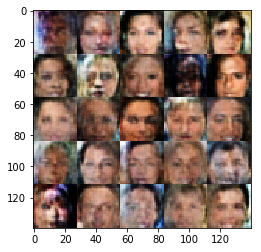

Epoch: 0/1, Discriminator Loss: 1.2683, Generator Loss: 0.8603
Epoch: 0/1, Discriminator Loss: 0.5795, Generator Loss: 2.1453
Epoch: 0/1, Discriminator Loss: 0.9913, Generator Loss: 1.0531
Epoch: 0/1, Discriminator Loss: 1.3162, Generator Loss: 1.0444
Epoch: 0/1, Discriminator Loss: 1.5724, Generator Loss: 0.4627
Epoch: 0/1, Discriminator Loss: 1.6432, Generator Loss: 0.2952
Epoch: 0/1, Discriminator Loss: 0.5763, Generator Loss: 2.6701
Epoch: 0/1, Discriminator Loss: 0.7692, Generator Loss: 1.0909
Epoch: 0/1, Discriminator Loss: 1.3136, Generator Loss: 0.6515
Epoch: 0/1, Discriminator Loss: 1.1395, Generator Loss: 0.6924


Epoch: 0/1, Discriminator Loss: 1.1048, Generator Loss: 0.9536
Epoch: 0/1, Discriminator Loss: 1.3648, Generator Loss: 0.4571
Epoch: 0/1, Discriminator Loss: 1.0634, Generator Loss: 0.7593
Epoch: 0/1, Discriminator Loss: 0.7036, Generator Loss: 2.6083
Epoch: 0/1, Discriminator Loss: 1.3822, Generator Loss: 0.5614
Epoch: 0/1, Discriminator Loss: 1.4963, Generator Loss: 0.5688
Epoch: 0/1, Discriminator Loss: 1.4072, Generator Loss: 0.4840
Epoch: 0/1, Discriminator Loss: 2.2002, Generator Loss: 0.1703
Epoch: 0/1, Discriminator Loss: 1.3545, Generator Loss: 0.8290
Epoch: 0/1, Discriminator Loss: 1.1667, Generator Loss: 0.7597


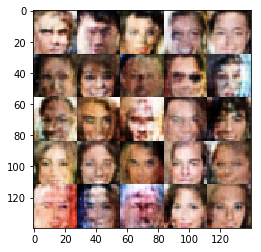

Epoch: 0/1, Discriminator Loss: 1.2983, Generator Loss: 0.7164
Epoch: 0/1, Discriminator Loss: 1.3459, Generator Loss: 0.7224
Epoch: 0/1, Discriminator Loss: 1.0046, Generator Loss: 0.9165
Epoch: 0/1, Discriminator Loss: 1.1991, Generator Loss: 0.7252
Epoch: 0/1, Discriminator Loss: 0.6358, Generator Loss: 1.8805
Epoch: 0/1, Discriminator Loss: 0.9391, Generator Loss: 1.3519
Epoch: 0/1, Discriminator Loss: 1.3688, Generator Loss: 0.6329
Epoch: 0/1, Discriminator Loss: 1.5888, Generator Loss: 0.3235
Epoch: 0/1, Discriminator Loss: 1.1052, Generator Loss: 1.0773
Epoch: 0/1, Discriminator Loss: 0.9821, Generator Loss: 0.7114


Epoch: 0/1, Discriminator Loss: 1.2385, Generator Loss: 0.8057
Epoch: 0/1, Discriminator Loss: 0.9791, Generator Loss: 1.1102
Epoch: 0/1, Discriminator Loss: 1.1536, Generator Loss: 1.5384
Epoch: 0/1, Discriminator Loss: 1.4901, Generator Loss: 2.4214
Epoch: 0/1, Discriminator Loss: 0.9603, Generator Loss: 1.3240
Epoch: 0/1, Discriminator Loss: 1.3586, Generator Loss: 0.5392
Epoch: 0/1, Discriminator Loss: 1.1424, Generator Loss: 0.9031
Epoch: 0/1, Discriminator Loss: 1.1346, Generator Loss: 0.8661
Epoch: 0/1, Discriminator Loss: 1.2122, Generator Loss: 0.4679
Epoch: 0/1, Discriminator Loss: 1.2250, Generator Loss: 0.7547


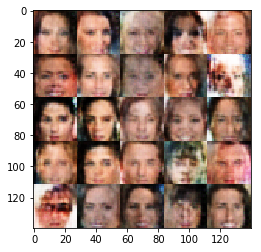

Epoch: 0/1, Discriminator Loss: 0.8834, Generator Loss: 2.0459
Epoch: 0/1, Discriminator Loss: 1.6364, Generator Loss: 0.3588
Epoch: 0/1, Discriminator Loss: 0.9460, Generator Loss: 1.0989
Epoch: 0/1, Discriminator Loss: 1.0181, Generator Loss: 1.0011
Epoch: 0/1, Discriminator Loss: 1.0306, Generator Loss: 1.8179
Epoch: 0/1, Discriminator Loss: 1.5454, Generator Loss: 0.3412
Epoch: 0/1, Discriminator Loss: 1.5906, Generator Loss: 0.7062
Epoch: 0/1, Discriminator Loss: 1.2380, Generator Loss: 1.2353
Epoch: 0/1, Discriminator Loss: 1.0145, Generator Loss: 1.2968
Epoch: 0/1, Discriminator Loss: 0.9458, Generator Loss: 1.0300


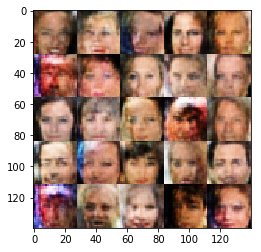

Epoch: 0/1, Discriminator Loss: 1.3305, Generator Loss: 0.5824
Epoch: 0/1, Discriminator Loss: 1.3968, Generator Loss: 0.5877
Epoch: 0/1, Discriminator Loss: 1.3142, Generator Loss: 0.6530
Epoch: 0/1, Discriminator Loss: 1.1905, Generator Loss: 0.8991
Epoch: 0/1, Discriminator Loss: 0.9856, Generator Loss: 1.0562
Epoch: 0/1, Discriminator Loss: 1.3073, Generator Loss: 0.6148
Epoch: 0/1, Discriminator Loss: 0.6371, Generator Loss: 1.3518
Epoch: 0/1, Discriminator Loss: 1.4094, Generator Loss: 0.6380
Epoch: 0/1, Discriminator Loss: 1.0043, Generator Loss: 0.8047
Epoch: 0/1, Discriminator Loss: 1.2784, Generator Loss: 0.5928


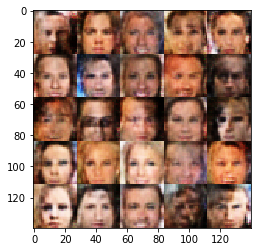

Epoch: 0/1, Discriminator Loss: 0.4928, Generator Loss: 2.1705
Epoch: 0/1, Discriminator Loss: 1.5609, Generator Loss: 0.5156
Epoch: 0/1, Discriminator Loss: 0.9435, Generator Loss: 1.3323
Epoch: 0/1, Discriminator Loss: 1.1194, Generator Loss: 0.9668
Epoch: 0/1, Discriminator Loss: 1.1855, Generator Loss: 0.5167
Epoch: 0/1, Discriminator Loss: 1.4069, Generator Loss: 0.8782
Epoch: 0/1, Discriminator Loss: 1.0341, Generator Loss: 0.6782
Epoch: 0/1, Discriminator Loss: 1.3570, Generator Loss: 0.6108
Epoch: 0/1, Discriminator Loss: 0.6915, Generator Loss: 1.3195
Epoch: 0/1, Discriminator Loss: 1.1762, Generator Loss: 0.6428


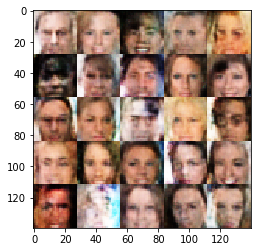

Epoch: 0/1, Discriminator Loss: 1.1464, Generator Loss: 1.0594
Epoch: 0/1, Discriminator Loss: 1.2788, Generator Loss: 0.4282
Epoch: 0/1, Discriminator Loss: 1.4542, Generator Loss: 0.5609
Epoch: 0/1, Discriminator Loss: 1.3142, Generator Loss: 0.6076
Epoch: 0/1, Discriminator Loss: 1.7036, Generator Loss: 0.3212
Epoch: 0/1, Discriminator Loss: 1.5360, Generator Loss: 0.6794
Epoch: 0/1, Discriminator Loss: 0.9101, Generator Loss: 1.0900
Epoch: 0/1, Discriminator Loss: 1.6532, Generator Loss: 0.4902
Epoch: 0/1, Discriminator Loss: 1.2081, Generator Loss: 1.1314
Epoch: 0/1, Discriminator Loss: 1.1974, Generator Loss: 0.7430


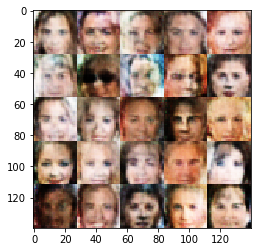

Epoch: 0/1, Discriminator Loss: 0.7728, Generator Loss: 2.2790
Epoch: 0/1, Discriminator Loss: 0.9598, Generator Loss: 0.7356
Epoch: 0/1, Discriminator Loss: 1.2105, Generator Loss: 0.7681
Epoch: 0/1, Discriminator Loss: 1.1219, Generator Loss: 0.6079
Epoch: 0/1, Discriminator Loss: 1.5766, Generator Loss: 0.5357
Epoch: 0/1, Discriminator Loss: 0.8237, Generator Loss: 2.3105
Epoch: 0/1, Discriminator Loss: 1.1177, Generator Loss: 0.7016
Epoch: 0/1, Discriminator Loss: 1.1123, Generator Loss: 0.9966
Epoch: 0/1, Discriminator Loss: 1.3425, Generator Loss: 0.5965
Epoch: 0/1, Discriminator Loss: 0.7108, Generator Loss: 1.5995


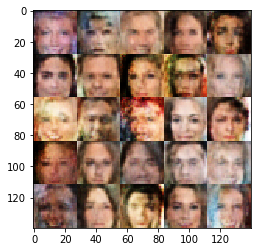

Epoch: 0/1, Discriminator Loss: 1.2526, Generator Loss: 0.7045
Epoch: 0/1, Discriminator Loss: 1.0522, Generator Loss: 0.7607
Epoch: 0/1, Discriminator Loss: 1.5049, Generator Loss: 0.6359
Epoch: 0/1, Discriminator Loss: 0.8442, Generator Loss: 1.4325
Epoch: 0/1, Discriminator Loss: 1.3678, Generator Loss: 0.6443
Epoch: 0/1, Discriminator Loss: 1.3724, Generator Loss: 0.3914
Epoch: 0/1, Discriminator Loss: 1.0144, Generator Loss: 0.8368
Epoch: 0/1, Discriminator Loss: 1.1320, Generator Loss: 0.9377
Epoch: 0/1, Discriminator Loss: 1.3680, Generator Loss: 0.7238
Epoch: 0/1, Discriminator Loss: 1.0528, Generator Loss: 1.0895


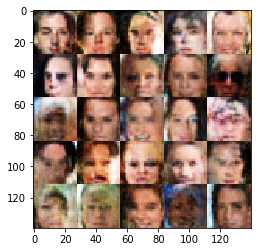

Epoch: 0/1, Discriminator Loss: 1.3346, Generator Loss: 0.5962
Epoch: 0/1, Discriminator Loss: 1.7600, Generator Loss: 0.2677
Epoch: 0/1, Discriminator Loss: 1.4517, Generator Loss: 0.5348
Epoch: 0/1, Discriminator Loss: 1.3324, Generator Loss: 0.7158
Epoch: 0/1, Discriminator Loss: 1.3385, Generator Loss: 0.6806
Epoch: 0/1, Discriminator Loss: 1.6872, Generator Loss: 0.3852
Epoch: 0/1, Discriminator Loss: 0.7134, Generator Loss: 2.1704
Epoch: 0/1, Discriminator Loss: 1.4043, Generator Loss: 0.6365
Epoch: 0/1, Discriminator Loss: 1.2395, Generator Loss: 0.7030
Epoch: 0/1, Discriminator Loss: 1.4078, Generator Loss: 0.6833


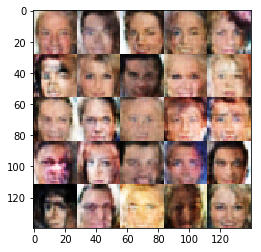

Epoch: 0/1, Discriminator Loss: 0.7594, Generator Loss: 2.0920
Epoch: 0/1, Discriminator Loss: 1.2717, Generator Loss: 0.7166
Epoch: 0/1, Discriminator Loss: 1.3681, Generator Loss: 0.5794
Epoch: 0/1, Discriminator Loss: 1.7231, Generator Loss: 0.2926
Epoch: 0/1, Discriminator Loss: 1.4519, Generator Loss: 0.5487
Epoch: 0/1, Discriminator Loss: 1.2757, Generator Loss: 0.7287
Epoch: 0/1, Discriminator Loss: 1.3028, Generator Loss: 0.6332
Epoch: 0/1, Discriminator Loss: 1.4817, Generator Loss: 0.5629
Epoch: 0/1, Discriminator Loss: 1.2921, Generator Loss: 0.7034
Epoch: 0/1, Discriminator Loss: 1.3623, Generator Loss: 0.5356


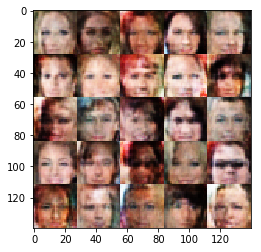

Epoch: 0/1, Discriminator Loss: 0.9900, Generator Loss: 0.8555
Epoch: 0/1, Discriminator Loss: 1.4187, Generator Loss: 0.6069
Epoch: 0/1, Discriminator Loss: 0.7585, Generator Loss: 1.2457
Epoch: 0/1, Discriminator Loss: 1.2822, Generator Loss: 0.6323
Epoch: 0/1, Discriminator Loss: 1.2258, Generator Loss: 0.7804
Epoch: 0/1, Discriminator Loss: 1.4131, Generator Loss: 0.6122
Epoch: 0/1, Discriminator Loss: 1.4848, Generator Loss: 0.6765
Epoch: 0/1, Discriminator Loss: 0.9114, Generator Loss: 1.2990
Epoch: 0/1, Discriminator Loss: 1.3838, Generator Loss: 0.7471
Epoch: 0/1, Discriminator Loss: 1.2428, Generator Loss: 0.6483


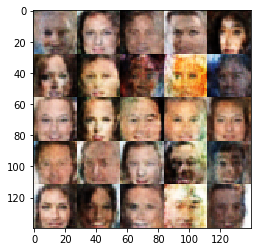

Epoch: 0/1, Discriminator Loss: 1.4738, Generator Loss: 0.5893
Epoch: 0/1, Discriminator Loss: 1.6122, Generator Loss: 0.3366
Epoch: 0/1, Discriminator Loss: 1.2460, Generator Loss: 0.6208
Epoch: 0/1, Discriminator Loss: 1.5490, Generator Loss: 0.5055
Epoch: 0/1, Discriminator Loss: 1.1313, Generator Loss: 1.0622
Epoch: 0/1, Discriminator Loss: 1.1484, Generator Loss: 0.7717
Epoch: 0/1, Discriminator Loss: 0.7878, Generator Loss: 1.6240
Epoch: 0/1, Discriminator Loss: 1.3300, Generator Loss: 0.6857
Epoch: 0/1, Discriminator Loss: 1.4744, Generator Loss: 0.5851
Epoch: 0/1, Discriminator Loss: 1.4795, Generator Loss: 0.5779


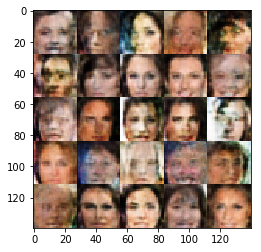

Epoch: 0/1, Discriminator Loss: 1.3638, Generator Loss: 0.5905
Epoch: 0/1, Discriminator Loss: 0.7475, Generator Loss: 1.7998
Epoch: 0/1, Discriminator Loss: 1.1225, Generator Loss: 0.8332
Epoch: 0/1, Discriminator Loss: 1.6386, Generator Loss: 0.4827
Epoch: 0/1, Discriminator Loss: 1.1040, Generator Loss: 0.7381
Epoch: 0/1, Discriminator Loss: 1.5156, Generator Loss: 0.5127
Epoch: 0/1, Discriminator Loss: 1.4860, Generator Loss: 0.5609
Epoch: 0/1, Discriminator Loss: 1.4289, Generator Loss: 0.6492
Epoch: 0/1, Discriminator Loss: 0.9153, Generator Loss: 1.0500
Epoch: 0/1, Discriminator Loss: 1.6493, Generator Loss: 0.4603


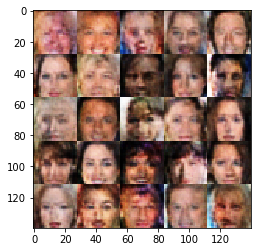

Epoch: 0/1, Discriminator Loss: 1.4215, Generator Loss: 0.5419
Epoch: 0/1, Discriminator Loss: 1.2315, Generator Loss: 0.6296
Epoch: 0/1, Discriminator Loss: 1.4113, Generator Loss: 0.6276
Epoch: 0/1, Discriminator Loss: 1.2828, Generator Loss: 0.6457
Epoch: 0/1, Discriminator Loss: 1.3525, Generator Loss: 0.5607
Epoch: 0/1, Discriminator Loss: 1.3956, Generator Loss: 0.6131
Epoch: 0/1, Discriminator Loss: 1.3555, Generator Loss: 0.6728
Epoch: 0/1, Discriminator Loss: 1.4522, Generator Loss: 0.4493
Epoch: 0/1, Discriminator Loss: 1.3796, Generator Loss: 0.5970
Epoch: 0/1, Discriminator Loss: 1.6723, Generator Loss: 0.5223


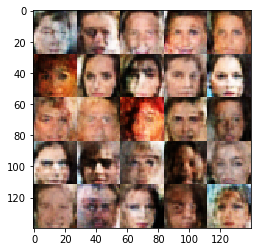

Epoch: 0/1, Discriminator Loss: 1.2726, Generator Loss: 0.6800
Epoch: 0/1, Discriminator Loss: 1.4256, Generator Loss: 0.5757
Epoch: 0/1, Discriminator Loss: 1.3383, Generator Loss: 0.6578


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.